In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/Users/zhuo/repos/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/Users/zhuo/repos/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/Users/zhuo/repos/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11'

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
BATCH_SIZE = 256
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 64

## Load Data

In [3]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [4]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [5]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    _mean = tf.repeat(_mean, N, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return data * _std + _mean

pos_timestamp_seqs = zcore_norm(raw_pos_timestamp_seqs)

In [6]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [7]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
    init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
    return init_token_noise, init_time_noise

## Create multitype SeqGan

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [9]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

In [10]:
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
# from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

# def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
#     # inputs of Time-LSTM:
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
        
#     token_logits = Dense(event_vocab_dim,
#                    activation='linear',
#                    name='dense_token',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
        
#     time_delta_out = Dense(1,
#                    activation='linear',
#                    name='dense_time',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(tm)
    
#     generator = Model(
#         inputs=[i_et, i_ts],
#         outputs=[token_logits, time_delta_out])
        
#     return generator

In [11]:
# def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
#     # normal LSTM
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
#     prob = Dense(1, 
#              activation='sigmoid',
#              name='final',
#              kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#              bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=prob)
#     return discriminator

## Define rollout and sequence generation

In [12]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [13]:
def rollout_from_initial_gumbel(G, batch_size, init_et, init_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
#     # LSTM-token
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     # LSTM-time
#     G.layers[5].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[5].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    
    # Time-LSTM
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        
        # add step noise to token and time inputs
#         curr_state_et = tf.cast(tf.where(curr_state_et == 1, 0.9, 0.1/3), tf.float64)
#         curr_state_ts = curr_state_ts + tf.random.truncated_normal(shape=tf.shape(curr_state_ts), mean=0.0, stddev=1, dtype=tf.float64)

        token_logits, time_delta_out = G([curr_state_et, curr_state_ts])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits, temperature=0.9)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :]


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_noise, init_time_noise = generate_initial_noise()
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_initial_gumbel(generator, batch_size, init_token_noise, init_time_noise, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

## Pre-Training of Gumbel-Softmax SeqGan

In [14]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

## Pre-train G

In [15]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)
_TOTAL_STEPS

46

In [16]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [17]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

  0%|          | 0/46 [00:00<?, ?it/s]

Training Step: 1


  2%|▏         | 1/46 [00:00<00:20,  2.23it/s]

token ce loss:1.3923794590398975
time mae loss:0.7982702301661903
train loss:2.190649689206088
Training Step: 2


  4%|▍         | 2/46 [00:00<00:17,  2.53it/s]

token ce loss:1.3749805049221693
time mae loss:0.7850064252156742
train loss:2.1599869301378436
Training Step: 3


  7%|▋         | 3/46 [00:01<00:16,  2.68it/s]

token ce loss:1.366146218165884
time mae loss:0.7937894115483809
train loss:2.159935629714265
Training Step: 4


  9%|▊         | 4/46 [00:01<00:15,  2.73it/s]

token ce loss:1.3541004559770042
time mae loss:0.7865351916004514
train loss:2.1406356475774557
Training Step: 5


 11%|█         | 5/46 [00:01<00:14,  2.74it/s]

token ce loss:1.3523065922471853
time mae loss:0.7853343218303933
train loss:2.1376409140775787
Training Step: 6


 13%|█▎        | 6/46 [00:02<00:14,  2.79it/s]

token ce loss:1.3424107116317991
time mae loss:0.7713209491070093
train loss:2.1137316607388086
Training Step: 7


 15%|█▌        | 7/46 [00:02<00:13,  2.82it/s]

token ce loss:1.3440493293067606
time mae loss:0.7825115027304306
train loss:2.126560832037191
Training Step: 8


 17%|█▋        | 8/46 [00:02<00:13,  2.82it/s]

token ce loss:1.3466784856841456
time mae loss:0.7853577058382688
train loss:2.132036191522414
Training Step: 9


 20%|█▉        | 9/46 [00:03<00:13,  2.82it/s]

token ce loss:1.351646162800223
time mae loss:0.7894358504913224
train loss:2.1410820132915456
Training Step: 10


 22%|██▏       | 10/46 [00:03<00:12,  2.78it/s]

token ce loss:1.3399428131702138
time mae loss:0.7711745631855401
train loss:2.111117376355754
Training Step: 11


 24%|██▍       | 11/46 [00:03<00:12,  2.83it/s]

token ce loss:1.3433641083353043
time mae loss:0.7916563448277001
train loss:2.1350204531630044
Training Step: 12


 26%|██▌       | 12/46 [00:04<00:11,  2.85it/s]

token ce loss:1.3436635311675147
time mae loss:0.7722902522770613
train loss:2.115953783444576
Training Step: 13


 28%|██▊       | 13/46 [00:04<00:11,  2.84it/s]

token ce loss:1.3478936219487496
time mae loss:0.7861135937252366
train loss:2.134007215673986
Training Step: 14


 30%|███       | 14/46 [00:05<00:11,  2.87it/s]

token ce loss:1.340177148421596
time mae loss:0.7784850766705252
train loss:2.1186622250921214
Training Step: 15


 33%|███▎      | 15/46 [00:05<00:11,  2.68it/s]

token ce loss:1.3416365949172053
time mae loss:0.7847686975370652
train loss:2.1264052924542707
Training Step: 16


 35%|███▍      | 16/46 [00:05<00:10,  2.77it/s]

token ce loss:1.3354333218948669
time mae loss:0.7864084473386099
train loss:2.121841769233477
Training Step: 17


 37%|███▋      | 17/46 [00:06<00:10,  2.83it/s]

token ce loss:1.3340807877364371
time mae loss:0.7703042933047637
train loss:2.104385081041201
Training Step: 18


 39%|███▉      | 18/46 [00:06<00:09,  2.86it/s]

token ce loss:1.3349894421708743
time mae loss:0.789754428626476
train loss:2.1247438707973503
Training Step: 19


 41%|████▏     | 19/46 [00:06<00:09,  2.84it/s]

token ce loss:1.3341948019193612
time mae loss:0.7833572614581019
train loss:2.117552063377463
Training Step: 20


 43%|████▎     | 20/46 [00:07<00:09,  2.82it/s]

token ce loss:1.3240286064828735
time mae loss:0.774341392480535
train loss:2.0983699989634084
Training Step: 21


 46%|████▌     | 21/46 [00:07<00:08,  2.83it/s]

token ce loss:1.3287219770941132
time mae loss:0.7834817176766351
train loss:2.1122036947707485
Training Step: 22


 48%|████▊     | 22/46 [00:07<00:08,  2.87it/s]

token ce loss:1.3282124752422824
time mae loss:0.7735660715281174
train loss:2.1017785467704
Training Step: 23


 50%|█████     | 23/46 [00:08<00:07,  2.91it/s]

token ce loss:1.3281397965349087
time mae loss:0.7787898793346537
train loss:2.106929675869562
Training Step: 24


 52%|█████▏    | 24/46 [00:08<00:07,  2.89it/s]

token ce loss:1.3321859720177218
time mae loss:0.7791556367322614
train loss:2.1113416087499832
Training Step: 25


 54%|█████▍    | 25/46 [00:08<00:07,  2.88it/s]

token ce loss:1.326862775614225
time mae loss:0.7875160362953968
train loss:2.1143788119096216
Training Step: 26


 57%|█████▋    | 26/46 [00:09<00:06,  2.89it/s]

token ce loss:1.32365041678572
time mae loss:0.7856417072600003
train loss:2.1092921240457203
Training Step: 27


 59%|█████▊    | 27/46 [00:09<00:06,  2.93it/s]

token ce loss:1.3233196738435244
time mae loss:0.7893556228856999
train loss:2.1126752967292246
Training Step: 28


 61%|██████    | 28/46 [00:09<00:06,  2.95it/s]

token ce loss:1.3243422067266202
time mae loss:0.7708554159882844
train loss:2.0951976227149047
Training Step: 29


 63%|██████▎   | 29/46 [00:10<00:05,  2.95it/s]

token ce loss:1.3207489060139412
time mae loss:0.7795507845570396
train loss:2.100299690570981
Training Step: 30


 65%|██████▌   | 30/46 [00:10<00:05,  2.88it/s]

token ce loss:1.315514242236229
time mae loss:0.7761986666907446
train loss:2.0917129089269735
Training Step: 31


 67%|██████▋   | 31/46 [00:10<00:05,  2.84it/s]

token ce loss:1.3169237942127332
time mae loss:0.7802949594058741
train loss:2.0972187536186073
Training Step: 32


 70%|██████▉   | 32/46 [00:11<00:04,  2.86it/s]

token ce loss:1.311915267326236
time mae loss:0.7606824411938289
train loss:2.072597708520065
Training Step: 33


 72%|███████▏  | 33/46 [00:11<00:04,  2.85it/s]

token ce loss:1.313279015996543
time mae loss:0.7745877385026165
train loss:2.0878667544991596
Training Step: 34


 74%|███████▍  | 34/46 [00:12<00:04,  2.89it/s]

token ce loss:1.3169357239380148
time mae loss:0.7843189479938202
train loss:2.101254671931835
Training Step: 35


 76%|███████▌  | 35/46 [00:12<00:03,  2.88it/s]

token ce loss:1.3100882988330955
time mae loss:0.77719464415991
train loss:2.0872829429930055
Training Step: 36


 78%|███████▊  | 36/46 [00:12<00:03,  2.88it/s]

token ce loss:1.311718398880533
time mae loss:0.781618161611196
train loss:2.093336560491729
Training Step: 37


 80%|████████  | 37/46 [00:13<00:03,  2.82it/s]

token ce loss:1.3132160854511852
time mae loss:0.775843434473372
train loss:2.0890595199245574
Training Step: 38


 83%|████████▎ | 38/46 [00:13<00:02,  2.87it/s]

token ce loss:1.3106573367943937
time mae loss:0.7932726041953138
train loss:2.1039299409897074
Training Step: 39


 85%|████████▍ | 39/46 [00:13<00:02,  2.82it/s]

token ce loss:1.3050201961236727
time mae loss:0.7712408139547193
train loss:2.076261010078392
Training Step: 40


 87%|████████▋ | 40/46 [00:14<00:02,  2.84it/s]

token ce loss:1.300631284151005
time mae loss:0.7701062539751726
train loss:2.0707375381261777
Training Step: 41


 89%|████████▉ | 41/46 [00:14<00:01,  2.85it/s]

token ce loss:1.3068798151854428
time mae loss:0.7860053447055853
train loss:2.0928851598910283
Training Step: 42


 91%|█████████▏| 42/46 [00:14<00:01,  2.84it/s]

token ce loss:1.3026657772645485
time mae loss:0.7798025335294029
train loss:2.0824683107939514
Training Step: 43


 93%|█████████▎| 43/46 [00:15<00:01,  2.89it/s]

token ce loss:1.3121511804060442
time mae loss:0.7966505668149224
train loss:2.1088017472209666
Training Step: 44


 96%|█████████▌| 44/46 [00:15<00:00,  2.93it/s]

token ce loss:1.3014519892261347
time mae loss:0.7809755048601261
train loss:2.082427494086261
Training Step: 45


 98%|█████████▊| 45/46 [00:15<00:00,  2.93it/s]

token ce loss:1.3052456804355155
time mae loss:0.775301159224796
train loss:2.0805468396603115
Training Step: 46


100%|██████████| 46/46 [00:16<00:00,  2.84it/s]

token ce loss:1.2996983135058602
time mae loss:0.7811253449165496
train loss:2.0808236584224096


In [18]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [19]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf.concat_1 (TFOpLambda)        (256, None, 17)      0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]        

## Pre-train D

In [20]:
N_fake_D = N_real_D = N_total_G 

In [21]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [22]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [23]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [24]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [25]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 100

for feature_batch, labels in tqdm(pretrain_D_dataset.take(100)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

  3%|▎         | 1/31 [00:00<00:04,  6.38it/s]

Training Step: 1
total discriminator loss:0.6945902060677038
Training Step: 2
total discriminator loss:0.6885165483044982


 10%|▉         | 3/31 [00:00<00:04,  6.73it/s]

Training Step: 3
total discriminator loss:0.6821092915166089
Training Step: 4


 13%|█▎        | 4/31 [00:00<00:03,  6.98it/s]

total discriminator loss:0.6764472232220182
Training Step: 5
total discriminator loss:0.6761272580455724


 19%|█▉        | 6/31 [00:00<00:03,  6.96it/s]

Training Step: 6
total discriminator loss:0.6598124991450278
Training Step: 7


 23%|██▎       | 7/31 [00:01<00:04,  5.62it/s]

total discriminator loss:0.6571344440755945
Training Step: 8
total discriminator loss:0.6447106126903315


 29%|██▉       | 9/31 [00:01<00:03,  6.57it/s]

Training Step: 9
total discriminator loss:0.6422078181882539
Training Step: 10
total discriminator loss:0.6436837658929203


 35%|███▌      | 11/31 [00:01<00:02,  7.16it/s]

Training Step: 11
total discriminator loss:0.636567355420489
Training Step: 12
total discriminator loss:0.6107800030820596


 42%|████▏     | 13/31 [00:01<00:02,  7.23it/s]

Training Step: 13
total discriminator loss:0.6058427312745276
Training Step: 14
total discriminator loss:0.6047948395882534


 48%|████▊     | 15/31 [00:02<00:02,  7.53it/s]

Training Step: 15
total discriminator loss:0.5982520197341787
Training Step: 16
total discriminator loss:0.6247568746233116


 55%|█████▍    | 17/31 [00:02<00:01,  7.63it/s]

Training Step: 17
total discriminator loss:0.5847119925252182
Training Step: 18
total discriminator loss:0.5400801803304787


 61%|██████▏   | 19/31 [00:02<00:01,  7.10it/s]

Training Step: 19
total discriminator loss:0.5301923695737363
Training Step: 20


 68%|██████▊   | 21/31 [00:02<00:01,  7.31it/s]

total discriminator loss:0.5342244226928214
Training Step: 21
total discriminator loss:0.5645169257618037
Training Step: 22


 71%|███████   | 22/31 [00:03<00:01,  7.21it/s]

total discriminator loss:0.5745299023049886
Training Step: 23
total discriminator loss:0.542360629892702


 77%|███████▋  | 24/31 [00:03<00:00,  7.32it/s]

Training Step: 24
total discriminator loss:0.4778811557650391
Training Step: 25
total discriminator loss:0.48495150389643005


 84%|████████▍ | 26/31 [00:03<00:00,  7.25it/s]

Training Step: 26
total discriminator loss:0.49612409802163115
Training Step: 27


 90%|█████████ | 28/31 [00:03<00:00,  7.44it/s]

total discriminator loss:0.5223213855537812
Training Step: 28
total discriminator loss:0.48345295873964866
Training Step: 29


 97%|█████████▋| 30/31 [00:04<00:00,  7.49it/s]

total discriminator loss:0.46280856071913884
Training Step: 30
total discriminator loss:0.4936984017271048
Training Step: 31


100%|██████████| 31/31 [00:04<00:00,  7.14it/s]

total discriminator loss:0.44822269944748105


In [26]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [27]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf.concat_3 (TFOpLambda)        (256, None, 17)      0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]        

## Gumbel  Traning

In [30]:
import tensorflow as tf
import tensorflow.keras.backend as K
keras = tf.keras

class HistoricalAvgLoss(object):
    def __init__(self, model):
        # create tensors (initialized to zero) to hold the previous value of the
        # weights
        self.model = model
        self.prev_weights = []
        for w in model.get_weights():
            self.prev_weights.append(K.variable(np.zeros(w.shape)))

    def loss(self, y_true, y_pred, from_logits=True):
        err = keras.losses.binary_crossentropy(y_true, y_pred, from_logits=from_logits)
#         err = tf.cast(y_true, tf.float64) * y_pred  # WGAN loss
        werr = [K.mean(K.square(c - p)) for c, p in zip(self.model.get_weights(), self.prev_weights)]
        self.prev_weights = \
            [K.update(p, c) for c, p in zip(self.model.get_weights(), self.prev_weights)]
        return err + K.sum(werr)


In [31]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001), loss_obj=None):
    
    assert loss_obj is not None
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator([G_sample_et, G_sample_ts])

#         generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        generator_loss =  tf.reduce_mean(loss_obj.loss(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False, loss_obj=None):

    assert loss_obj is not None
    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
#         discriminator_loss = tf.reduce_mean(
#             tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))
        
        discriminator_loss = tf.reduce_mean(loss_obj.loss(total_labels, pred_prob, from_logits=False))
        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [32]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

historical_avg_G = HistoricalAvgLoss(G)
historical_avg_D = HistoricalAvgLoss(D)

assert historical_avg_G.model is G
assert historical_avg_D.model is D

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf.concat_4 (TFOpLambda)        (256, None, 17)      0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]        

In [33]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-3)

_G_STEPS = 1
_D_STEPS = 1

  0%|          | 0/500 [00:00<?, ?it/s]

Training Step: 0
generator loss:2.374151427068319
-----------------------
total discriminator loss:1.3224805161267479
average true return:0.5098105139867917
-----------------------
tf.Tensor([[3 2 2 0 2 1 1 0 2 3 0 1 2 3 2 0 1 1 2 2]], shape=(1, 20), dtype=int64)


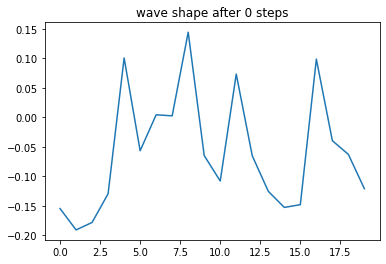

  0%|          | 1/500 [00:01<10:08,  1.22s/it]

Training Step: 1
generator loss:1.3067212261165717
-----------------------


  0%|          | 2/500 [00:02<08:09,  1.02it/s]

total discriminator loss:0.745058648981934
average true return:0.465874249601459
-----------------------
Training Step: 2
generator loss:1.0103211485640071
-----------------------


  1%|          | 3/500 [00:02<07:34,  1.09it/s]

total discriminator loss:0.8812117149497083
average true return:0.4851638837142712
-----------------------
Training Step: 3
generator loss:0.7958766576449391
-----------------------


  1%|          | 4/500 [00:03<07:13,  1.14it/s]

total discriminator loss:0.5836905446373564
average true return:0.5623035582640487
-----------------------
Training Step: 4
generator loss:0.5355738987508465
-----------------------


  1%|          | 5/500 [00:04<07:03,  1.17it/s]

total discriminator loss:1.3783073398910237
average true return:0.5907421428403772
-----------------------
Training Step: 5
generator loss:0.3993605122151781
-----------------------


  1%|          | 6/500 [00:05<06:53,  1.19it/s]

total discriminator loss:1.4758295623760027
average true return:0.6225185925183028
-----------------------
Training Step: 6
generator loss:0.279239506046239
-----------------------


  1%|▏         | 7/500 [00:06<06:49,  1.20it/s]

total discriminator loss:1.4298454682340762
average true return:0.6471579902256458
-----------------------
Training Step: 7
generator loss:0.20389977512485244
-----------------------


  2%|▏         | 8/500 [00:06<06:51,  1.20it/s]

total discriminator loss:1.343919450002157
average true return:0.6726493252333
-----------------------
Training Step: 8
generator loss:0.18137470349110632
-----------------------


  2%|▏         | 9/500 [00:07<06:48,  1.20it/s]

total discriminator loss:1.2998454653960394
average true return:0.675090602305277
-----------------------
Training Step: 9
generator loss:0.1842562092119405
-----------------------


  2%|▏         | 10/500 [00:08<06:46,  1.20it/s]

total discriminator loss:1.2668663861907032
average true return:0.6704848405845132
-----------------------
Training Step: 10
generator loss:0.18556947884814357
-----------------------


  2%|▏         | 11/500 [00:09<06:48,  1.20it/s]

total discriminator loss:1.2051821207671178
average true return:0.6662083055173945
-----------------------
Training Step: 11
generator loss:0.19795889858744622
-----------------------


  2%|▏         | 12/500 [00:10<06:46,  1.20it/s]

total discriminator loss:1.179477939485182
average true return:0.6558447790925208
-----------------------
Training Step: 12
generator loss:0.21245563174727794
-----------------------


  3%|▎         | 13/500 [00:11<06:43,  1.21it/s]

total discriminator loss:1.1046100506827314
average true return:0.6487209615965446
-----------------------
Training Step: 13
generator loss:0.2350124485081246
-----------------------


  3%|▎         | 14/500 [00:11<06:46,  1.19it/s]

total discriminator loss:1.054516402496075
average true return:0.6392396237926771
-----------------------
Training Step: 14
generator loss:0.2644266211587516
-----------------------


  3%|▎         | 15/500 [00:12<06:43,  1.20it/s]

total discriminator loss:0.994709760848592
average true return:0.6240700892287023
-----------------------
Training Step: 15
generator loss:0.29728438838269167
-----------------------


  3%|▎         | 16/500 [00:13<06:43,  1.20it/s]

total discriminator loss:0.9430655284079045
average true return:0.6130194360250667
-----------------------
Training Step: 16
generator loss:0.3467849799846532
-----------------------


  3%|▎         | 17/500 [00:14<06:44,  1.19it/s]

total discriminator loss:0.883286247965635
average true return:0.5954082676443018
-----------------------
Training Step: 17
generator loss:0.39813588682121004
-----------------------


  4%|▎         | 18/500 [00:15<06:40,  1.20it/s]

total discriminator loss:0.8383215800383947
average true return:0.582254335609221
-----------------------
Training Step: 18
generator loss:0.45378733500349366
-----------------------


  4%|▍         | 19/500 [00:16<06:37,  1.21it/s]

total discriminator loss:0.6277089799072473
average true return:0.5686947599661573
-----------------------
Training Step: 19
generator loss:0.5011770220719105
-----------------------


  4%|▍         | 20/500 [00:16<06:38,  1.20it/s]

total discriminator loss:0.76615676286295
average true return:0.5598693308349545
-----------------------
Training Step: 20
generator loss:0.5440930802190996
-----------------------


  4%|▍         | 21/500 [00:17<06:36,  1.21it/s]

total discriminator loss:0.7457462561589234
average true return:0.5513987768558755
-----------------------
Training Step: 21
generator loss:0.5811643057414878
-----------------------


  4%|▍         | 22/500 [00:18<06:38,  1.20it/s]

total discriminator loss:0.7210842747250578
average true return:0.5463220505868545
-----------------------
Training Step: 22
generator loss:0.6165481970083212
-----------------------


  5%|▍         | 23/500 [00:19<06:37,  1.20it/s]

total discriminator loss:0.6993957257722816
average true return:0.541520620197468
-----------------------
Training Step: 23
generator loss:0.6541769610395376
-----------------------


  5%|▍         | 24/500 [00:20<06:36,  1.20it/s]

total discriminator loss:0.6758112467644994
average true return:0.5350993225641114
-----------------------
Training Step: 24
generator loss:0.6929254086591958
-----------------------


  5%|▌         | 25/500 [00:21<06:32,  1.21it/s]

total discriminator loss:0.6577113278477658
average true return:0.5276915954111701
-----------------------
Training Step: 25
generator loss:0.7350487295116
-----------------------
total discriminator loss:0.6367929218073187
average true return:0.5193744569857296
-----------------------
tf.Tensor([[1 1 1 0 0 2 2 2 3 3 1 2 1 1 2 1 3 0 2 2]], shape=(1, 20), dtype=int64)


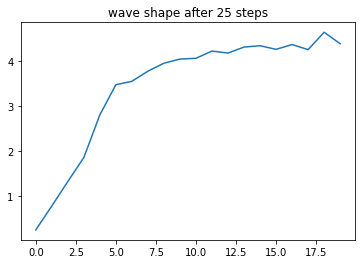

  5%|▌         | 26/500 [00:22<07:12,  1.10it/s]

Training Step: 26
generator loss:0.7819161950868028
-----------------------


  5%|▌         | 27/500 [00:23<06:58,  1.13it/s]

total discriminator loss:0.6140792302139333
average true return:0.510602422741668
-----------------------
Training Step: 27
generator loss:0.8306576159327113
-----------------------


  6%|▌         | 28/500 [00:23<06:46,  1.16it/s]

total discriminator loss:0.5933136903493396
average true return:0.4990892928018951
-----------------------
Training Step: 28
generator loss:0.8886668036034632
-----------------------


  6%|▌         | 29/500 [00:24<06:38,  1.18it/s]

total discriminator loss:0.5762071818905273
average true return:0.4893520483170867
-----------------------
Training Step: 29
generator loss:0.9457229022106479
-----------------------


  6%|▌         | 30/500 [00:25<06:34,  1.19it/s]

total discriminator loss:0.5630979817056735
average true return:0.4799502831517138
-----------------------
Training Step: 30
generator loss:1.0017063168547788
-----------------------


  6%|▌         | 31/500 [00:26<06:29,  1.21it/s]

total discriminator loss:0.5398711039784293
average true return:0.47358092958036907
-----------------------
Training Step: 31
generator loss:1.0612322786375281
-----------------------


  6%|▋         | 32/500 [00:27<06:25,  1.21it/s]

total discriminator loss:0.520327441490845
average true return:0.4645168238896394
-----------------------
Training Step: 32
generator loss:1.1186458280904548
-----------------------


  7%|▋         | 33/500 [00:28<06:43,  1.16it/s]

total discriminator loss:0.5028998298962817
average true return:0.46131241642369525
-----------------------
Training Step: 33
generator loss:1.1747140395489781
-----------------------


  7%|▋         | 34/500 [00:28<06:47,  1.14it/s]

total discriminator loss:0.48301090419452875
average true return:0.45743208903039073
-----------------------
Training Step: 34
generator loss:1.2282839066599913
-----------------------


  7%|▋         | 35/500 [00:29<06:41,  1.16it/s]

total discriminator loss:0.48496533735274366
average true return:0.45623065931788526
-----------------------
Training Step: 35
generator loss:1.2764957340628635
-----------------------


  7%|▋         | 36/500 [00:30<06:34,  1.17it/s]

total discriminator loss:0.46504186999512587
average true return:0.45601263708794026
-----------------------
Training Step: 36
generator loss:1.3186084594837748
-----------------------


  7%|▋         | 37/500 [00:31<06:29,  1.19it/s]

total discriminator loss:0.4320996966423166
average true return:0.45961388594725405
-----------------------
Training Step: 37
generator loss:1.3534370240760345
-----------------------


  8%|▊         | 38/500 [00:32<06:25,  1.20it/s]

total discriminator loss:0.44056701093094963
average true return:0.4634891087109162
-----------------------
Training Step: 38
generator loss:1.3832105537384183
-----------------------


  8%|▊         | 39/500 [00:33<06:21,  1.21it/s]

total discriminator loss:0.42424414575883085
average true return:0.4692085380678176
-----------------------
Training Step: 39
generator loss:1.4013079426576467
-----------------------


  8%|▊         | 40/500 [00:33<06:18,  1.21it/s]

total discriminator loss:0.40730418035485866
average true return:0.47629980969638747
-----------------------
Training Step: 40
generator loss:1.408005717904317
-----------------------


  8%|▊         | 41/500 [00:34<06:18,  1.21it/s]

total discriminator loss:0.4023599925037319
average true return:0.48457981491921487
-----------------------
Training Step: 41
generator loss:1.4025356887687226
-----------------------


  8%|▊         | 42/500 [00:35<06:18,  1.21it/s]

total discriminator loss:1.274171760555285
average true return:0.49431466836265797
-----------------------
Training Step: 42
generator loss:1.3474128422402503
-----------------------


  9%|▊         | 43/500 [00:36<06:24,  1.19it/s]

total discriminator loss:0.40282621473496316
average true return:0.5098079637780124
-----------------------
Training Step: 43
generator loss:1.2749440970982926
-----------------------


  9%|▉         | 44/500 [00:37<06:23,  1.19it/s]

total discriminator loss:0.4153399382932365
average true return:0.5240775107923275
-----------------------
Training Step: 44
generator loss:1.2063650429308552
-----------------------


  9%|▉         | 45/500 [00:38<06:21,  1.19it/s]

total discriminator loss:0.42126723224799956
average true return:0.5400609529147191
-----------------------
Training Step: 45
generator loss:1.1433018681840017
-----------------------


  9%|▉         | 46/500 [00:38<06:18,  1.20it/s]

total discriminator loss:0.42776843616863225
average true return:0.5506823864024029
-----------------------
Training Step: 46
generator loss:1.0833325972502696
-----------------------


  9%|▉         | 47/500 [00:39<06:27,  1.17it/s]

total discriminator loss:0.42032391017280246
average true return:0.561609408736964
-----------------------
Training Step: 47
generator loss:1.0432149557920047
-----------------------


 10%|▉         | 48/500 [00:40<06:21,  1.18it/s]

total discriminator loss:0.44247910024883913
average true return:0.5652228079385204
-----------------------
Training Step: 48
generator loss:1.0192655019505859
-----------------------


 10%|▉         | 49/500 [00:41<06:18,  1.19it/s]

total discriminator loss:0.4192437676208103
average true return:0.5658812983428895
-----------------------
Training Step: 49
generator loss:1.0108924936199495
-----------------------


 10%|█         | 50/500 [00:42<06:24,  1.17it/s]

total discriminator loss:0.4223659403997396
average true return:0.5587542677506461
-----------------------
Training Step: 50
generator loss:1.0219935387897392
-----------------------
total discriminator loss:0.4053056429862669
average true return:0.5510860269318003
-----------------------
tf.Tensor([[1 2 2 1 0 2 2 2 1 0 3 2 2 2 2 2 3 2 1 2]], shape=(1, 20), dtype=int64)


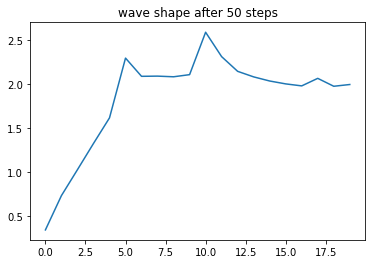

 10%|█         | 51/500 [00:43<07:01,  1.06it/s]

Training Step: 51
generator loss:1.0213006361220807
-----------------------


 10%|█         | 52/500 [00:44<06:46,  1.10it/s]

total discriminator loss:0.41828465007266274
average true return:0.5421811610527056
-----------------------
Training Step: 52
generator loss:1.0458092069147877
-----------------------


 11%|█         | 53/500 [00:45<06:33,  1.14it/s]

total discriminator loss:0.40921117004753543
average true return:0.5330254164144863
-----------------------
Training Step: 53
generator loss:1.0527673811899068
-----------------------


 11%|█         | 54/500 [00:45<06:25,  1.16it/s]

total discriminator loss:0.41619193582221453
average true return:0.5186346656098684
-----------------------
Training Step: 54
generator loss:1.0553089753278764
-----------------------


 11%|█         | 55/500 [00:46<06:18,  1.18it/s]

total discriminator loss:0.4128630081097789
average true return:0.5041597734753065
-----------------------
Training Step: 55
generator loss:1.0539755612441304
-----------------------


 11%|█         | 56/500 [00:47<06:14,  1.18it/s]

total discriminator loss:0.40821264307121485
average true return:0.4953529215145787
-----------------------
Training Step: 56
generator loss:1.0519545487178403
-----------------------


 11%|█▏        | 57/500 [00:48<06:10,  1.20it/s]

total discriminator loss:0.39642142172037376
average true return:0.4896953210121131
-----------------------
Training Step: 57
generator loss:1.034127237913334
-----------------------


 12%|█▏        | 58/500 [00:49<06:07,  1.20it/s]

total discriminator loss:0.43079072321723144
average true return:0.48308536399185614
-----------------------
Training Step: 58
generator loss:1.018012574681057
-----------------------


 12%|█▏        | 59/500 [00:50<06:06,  1.20it/s]

total discriminator loss:0.4126323340777494
average true return:0.48540871122012774
-----------------------
Training Step: 59
generator loss:0.9868702433490888
-----------------------


 12%|█▏        | 60/500 [00:50<06:04,  1.21it/s]

total discriminator loss:0.412373994278336
average true return:0.4900428529583768
-----------------------
Training Step: 60
generator loss:0.9607366553112759
-----------------------


 12%|█▏        | 61/500 [00:51<06:02,  1.21it/s]

total discriminator loss:0.40700755016796714
average true return:0.5002285218931696
-----------------------
Training Step: 61
generator loss:0.9212755779952772
-----------------------


 12%|█▏        | 62/500 [00:52<06:00,  1.21it/s]

total discriminator loss:0.4154478715661416
average true return:0.5099959476696646
-----------------------
Training Step: 62
generator loss:0.8852992104239886
-----------------------


 13%|█▎        | 63/500 [00:53<05:59,  1.21it/s]

total discriminator loss:0.39029030478953214
average true return:0.5183685484114522
-----------------------
Training Step: 63
generator loss:0.8611412870939444
-----------------------


 13%|█▎        | 64/500 [00:54<05:59,  1.21it/s]

total discriminator loss:0.3877635895692556
average true return:0.5280001542603424
-----------------------
Training Step: 64
generator loss:0.8506609748188432
-----------------------


 13%|█▎        | 65/500 [00:54<05:58,  1.21it/s]

total discriminator loss:0.38751065922888983
average true return:0.5206378825901673
-----------------------
Training Step: 65
generator loss:0.8736402737698021
-----------------------


 13%|█▎        | 66/500 [00:55<05:57,  1.22it/s]

total discriminator loss:0.400618416303654
average true return:0.5120770776616007
-----------------------
Training Step: 66
generator loss:0.8921742262336523
-----------------------


 13%|█▎        | 67/500 [00:56<05:57,  1.21it/s]

total discriminator loss:0.3985782485671595
average true return:0.49965658042667943
-----------------------
Training Step: 67
generator loss:0.924391918659759
-----------------------


 14%|█▎        | 68/500 [00:57<05:56,  1.21it/s]

total discriminator loss:0.38136265419455073
average true return:0.4874111458584499
-----------------------
Training Step: 68
generator loss:0.9685070377577691
-----------------------


 14%|█▍        | 69/500 [00:58<05:55,  1.21it/s]

total discriminator loss:0.38889259858034764
average true return:0.4665966339795798
-----------------------
Training Step: 69
generator loss:1.0094258929108608
-----------------------


 14%|█▍        | 70/500 [00:59<05:54,  1.21it/s]

total discriminator loss:0.3792041278461039
average true return:0.45502683369361163
-----------------------
Training Step: 70
generator loss:1.0375808597805394
-----------------------


 14%|█▍        | 71/500 [00:59<05:54,  1.21it/s]

total discriminator loss:0.39007201609988046
average true return:0.45078452562515414
-----------------------
Training Step: 71
generator loss:1.0326691244548791
-----------------------


 14%|█▍        | 72/500 [01:00<05:54,  1.21it/s]

total discriminator loss:0.37781794036698385
average true return:0.4542064794664395
-----------------------
Training Step: 72
generator loss:1.0352358219064302
-----------------------


 15%|█▍        | 73/500 [01:01<05:53,  1.21it/s]

total discriminator loss:0.3695522265713363
average true return:0.4557905574101794
-----------------------
Training Step: 73
generator loss:1.0448861635351767
-----------------------


 15%|█▍        | 74/500 [01:02<05:51,  1.21it/s]

total discriminator loss:0.36183447664816776
average true return:0.45772352406912253
-----------------------
Training Step: 74
generator loss:1.0596017366157828
-----------------------


 15%|█▌        | 75/500 [01:03<05:51,  1.21it/s]

total discriminator loss:0.3593642284194636
average true return:0.4581517102371379
-----------------------
Training Step: 75
generator loss:1.0624051739645766
-----------------------
total discriminator loss:0.3495948199983252
average true return:0.4656704781882408
-----------------------
tf.Tensor([[2 2 1 1 1 2 3 2 1 3 1 3 3 0 1 1 2 3 1 2]], shape=(1, 20), dtype=int64)


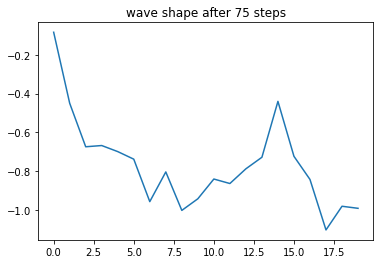

 15%|█▌        | 76/500 [01:04<06:29,  1.09it/s]

Training Step: 76
generator loss:1.0498822167476414
-----------------------


 15%|█▌        | 77/500 [01:05<06:18,  1.12it/s]

total discriminator loss:0.3429654156300596
average true return:0.4729762424020265
-----------------------
Training Step: 77
generator loss:1.0119107200689772
-----------------------


 16%|█▌        | 78/500 [01:06<06:08,  1.15it/s]

total discriminator loss:0.35210122975739566
average true return:0.4951508929567272
-----------------------
Training Step: 78
generator loss:0.8813337635972893
-----------------------


 16%|█▌        | 79/500 [01:06<06:15,  1.12it/s]

total discriminator loss:0.38955466094787167
average true return:0.5356875933293344
-----------------------
Training Step: 79
generator loss:0.7249043841668148
-----------------------


 16%|█▌        | 80/500 [01:07<06:05,  1.15it/s]

total discriminator loss:1.2989306445200368
average true return:0.57886368893898
-----------------------
Training Step: 80
generator loss:0.5687602041382036
-----------------------


 16%|█▌        | 81/500 [01:08<05:59,  1.16it/s]

total discriminator loss:0.46603256124980985
average true return:0.622134650061944
-----------------------
Training Step: 81
generator loss:0.5156533714658748
-----------------------


 16%|█▋        | 82/500 [01:09<05:54,  1.18it/s]

total discriminator loss:0.5068830506215842
average true return:0.6364742126597683
-----------------------
Training Step: 82
generator loss:0.526244519396415
-----------------------


 17%|█▋        | 83/500 [01:10<05:50,  1.19it/s]

total discriminator loss:0.46700220136741993
average true return:0.6190369983381802
-----------------------
Training Step: 83
generator loss:0.6301264513492972
-----------------------


 17%|█▋        | 84/500 [01:11<05:46,  1.20it/s]

total discriminator loss:0.45023234811117535
average true return:0.5810022901053149
-----------------------
Training Step: 84
generator loss:0.7220219853769014
-----------------------


 17%|█▋        | 85/500 [01:11<05:44,  1.20it/s]

total discriminator loss:0.39016046170077134
average true return:0.5528622936616991
-----------------------
Training Step: 85
generator loss:0.8061525077220972
-----------------------


 17%|█▋        | 86/500 [01:12<05:42,  1.21it/s]

total discriminator loss:0.37517406003379583
average true return:0.5326721505819856
-----------------------
Training Step: 86
generator loss:0.8739680838110848
-----------------------


 17%|█▋        | 87/500 [01:13<05:41,  1.21it/s]

total discriminator loss:0.3748747389788669
average true return:0.5190267438217293
-----------------------
Training Step: 87
generator loss:0.925531491337551
-----------------------


 18%|█▊        | 88/500 [01:14<05:39,  1.21it/s]

total discriminator loss:0.36689791619481055
average true return:0.5103544073578332
-----------------------
Training Step: 88
generator loss:0.9667148836100439
-----------------------


 18%|█▊        | 89/500 [01:15<05:39,  1.21it/s]

total discriminator loss:0.36294866452077545
average true return:0.5013783523494619
-----------------------
Training Step: 89
generator loss:1.0082470426376937
-----------------------


 18%|█▊        | 90/500 [01:16<05:38,  1.21it/s]

total discriminator loss:0.34968612073495453
average true return:0.49944661259512174
-----------------------
Training Step: 90
generator loss:1.0399829416105029
-----------------------


 18%|█▊        | 91/500 [01:16<05:36,  1.22it/s]

total discriminator loss:0.35322074444257195
average true return:0.49644680016193643
-----------------------
Training Step: 91
generator loss:1.0661345636227244
-----------------------


 18%|█▊        | 92/500 [01:17<05:36,  1.21it/s]

total discriminator loss:0.3459396572663487
average true return:0.49570783060345525
-----------------------
Training Step: 92
generator loss:1.0748164346389375
-----------------------


 19%|█▊        | 93/500 [01:18<05:45,  1.18it/s]

total discriminator loss:0.3554013231471508
average true return:0.4972462414447379
-----------------------
Training Step: 93
generator loss:1.0877662139020288
-----------------------


 19%|█▉        | 94/500 [01:19<05:42,  1.19it/s]

total discriminator loss:0.35114113683507703
average true return:0.5014646162419562
-----------------------
Training Step: 94
generator loss:1.0739905268676733
-----------------------


 19%|█▉        | 95/500 [01:20<05:40,  1.19it/s]

total discriminator loss:0.3680969688910413
average true return:0.50365938146847
-----------------------
Training Step: 95
generator loss:1.0605128535813986
-----------------------


 19%|█▉        | 96/500 [01:21<05:37,  1.20it/s]

total discriminator loss:0.3559613269868168
average true return:0.5115527872946317
-----------------------
Training Step: 96
generator loss:1.0315656444799042
-----------------------


 19%|█▉        | 97/500 [01:21<05:34,  1.21it/s]

total discriminator loss:0.35305273856080904
average true return:0.5177548632450786
-----------------------
Training Step: 97
generator loss:1.0200839239540973
-----------------------


 20%|█▉        | 98/500 [01:22<05:32,  1.21it/s]

total discriminator loss:0.32228914339627057
average true return:0.5181448845403075
-----------------------
Training Step: 98
generator loss:1.0425166340903114
-----------------------


 20%|█▉        | 99/500 [01:23<05:30,  1.21it/s]

total discriminator loss:1.6548528342672855
average true return:0.515195766645385
-----------------------
Training Step: 99
generator loss:1.041619124164755
-----------------------


 20%|██        | 100/500 [01:24<05:30,  1.21it/s]

total discriminator loss:0.33813190754689976
average true return:0.5150237170907926
-----------------------
Training Step: 100
generator loss:1.044891133167658
-----------------------
total discriminator loss:0.32825636070083497
average true return:0.513481498325189
-----------------------
tf.Tensor([[2 0 1 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 20), dtype=int64)


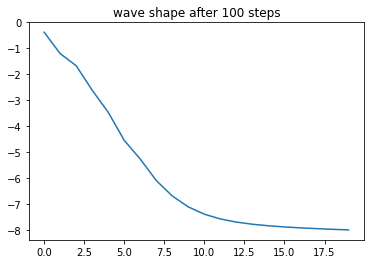

 20%|██        | 101/500 [01:25<06:07,  1.09it/s]

Training Step: 101
generator loss:1.0517691732497385
-----------------------


 20%|██        | 102/500 [01:26<05:58,  1.11it/s]

total discriminator loss:1.6177562937089305
average true return:0.5129597819031619
-----------------------
Training Step: 102
generator loss:1.0353694585793523
-----------------------


 21%|██        | 103/500 [01:27<05:49,  1.14it/s]

total discriminator loss:0.35223990350798606
average true return:0.5136202512545052
-----------------------
Training Step: 103
generator loss:1.0263297414509363
-----------------------


 21%|██        | 104/500 [01:28<05:41,  1.16it/s]

total discriminator loss:0.3489590472007166
average true return:0.5135157700994963
-----------------------
Training Step: 104
generator loss:1.022173387018631
-----------------------


 21%|██        | 105/500 [01:28<05:36,  1.17it/s]

total discriminator loss:0.37196033009764184
average true return:0.5139888596635158
-----------------------
Training Step: 105
generator loss:1.0268227057427841
-----------------------


 21%|██        | 106/500 [01:29<05:32,  1.19it/s]

total discriminator loss:0.37810988747431146
average true return:0.5120934706276457
-----------------------
Training Step: 106
generator loss:1.0314239160113439
-----------------------


 21%|██▏       | 107/500 [01:30<05:29,  1.19it/s]

total discriminator loss:0.35956993393270015
average true return:0.5101520222632729
-----------------------
Training Step: 107
generator loss:1.0442172985113014
-----------------------


 22%|██▏       | 108/500 [01:31<05:26,  1.20it/s]

total discriminator loss:0.3720854793373274
average true return:0.5024328820045758
-----------------------
Training Step: 108
generator loss:1.0679559641767717
-----------------------


 22%|██▏       | 109/500 [01:32<05:23,  1.21it/s]

total discriminator loss:0.37003256339727164
average true return:0.49823826819110045
-----------------------
Training Step: 109
generator loss:1.0865143646467055
-----------------------


 22%|██▏       | 110/500 [01:32<05:22,  1.21it/s]

total discriminator loss:0.3898130266887063
average true return:0.49608183329156824
-----------------------
Training Step: 110
generator loss:1.0980283131863975
-----------------------


 22%|██▏       | 111/500 [01:33<05:21,  1.21it/s]

total discriminator loss:0.38908388134078464
average true return:0.49478752506802337
-----------------------
Training Step: 111
generator loss:1.1139715723763692
-----------------------


 22%|██▏       | 112/500 [01:34<05:20,  1.21it/s]

total discriminator loss:0.3839701936224046
average true return:0.4914324817733411
-----------------------
Training Step: 112
generator loss:1.1372468139730985
-----------------------


 23%|██▎       | 113/500 [01:35<05:19,  1.21it/s]

total discriminator loss:0.3697460926745358
average true return:0.4901992094536074
-----------------------
Training Step: 113
generator loss:1.1567315584586986
-----------------------


 23%|██▎       | 114/500 [01:36<05:17,  1.21it/s]

total discriminator loss:0.37271997801032186
average true return:0.48863830277100473
-----------------------
Training Step: 114
generator loss:1.1787530852537695
-----------------------


 23%|██▎       | 115/500 [01:37<05:18,  1.21it/s]

total discriminator loss:0.37590269183895453
average true return:0.48746889367815976
-----------------------
Training Step: 115
generator loss:1.2000498807623323
-----------------------


 23%|██▎       | 116/500 [01:37<05:18,  1.21it/s]

total discriminator loss:0.35737909746287766
average true return:0.48649863123710047
-----------------------
Training Step: 116
generator loss:1.2218616969357534
-----------------------


 23%|██▎       | 117/500 [01:38<05:16,  1.21it/s]

total discriminator loss:0.37324573693952173
average true return:0.4855102617303329
-----------------------
Training Step: 117
generator loss:1.2433825639973413
-----------------------


 24%|██▎       | 118/500 [01:39<05:15,  1.21it/s]

total discriminator loss:1.720527313239003
average true return:0.4850536636197219
-----------------------
Training Step: 118
generator loss:1.2361547284057184
-----------------------


 24%|██▍       | 119/500 [01:40<05:14,  1.21it/s]

total discriminator loss:0.3528978798444401
average true return:0.4849607676207278
-----------------------
Training Step: 119
generator loss:1.2322842086731562
-----------------------


 24%|██▍       | 120/500 [01:41<05:13,  1.21it/s]

total discriminator loss:0.3577375816358501
average true return:0.48478156495746005
-----------------------
Training Step: 120
generator loss:1.2300184301959167
-----------------------


 24%|██▍       | 121/500 [01:42<05:11,  1.22it/s]

total discriminator loss:0.3528754745174634
average true return:0.4852793538202531
-----------------------
Training Step: 121
generator loss:1.2293159624824561
-----------------------


 24%|██▍       | 122/500 [01:42<05:21,  1.17it/s]

total discriminator loss:0.36178406874077673
average true return:0.48584700310765194
-----------------------
Training Step: 122
generator loss:1.2302076890746996
-----------------------


 25%|██▍       | 123/500 [01:43<05:17,  1.19it/s]

total discriminator loss:0.3588174783438729
average true return:0.48619023494050717
-----------------------
Training Step: 123
generator loss:1.2318939336532244
-----------------------


 25%|██▍       | 124/500 [01:44<05:15,  1.19it/s]

total discriminator loss:0.3628021124556231
average true return:0.48638068753929853
-----------------------
Training Step: 124
generator loss:1.2347442178225267
-----------------------


 25%|██▌       | 125/500 [01:45<05:13,  1.20it/s]

total discriminator loss:0.35606742814269043
average true return:0.4868851907484446
-----------------------
Training Step: 125
generator loss:1.2382772274947862
-----------------------
total discriminator loss:0.35997532820727846
average true return:0.4876329253035899
-----------------------
tf.Tensor([[2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 20), dtype=int64)


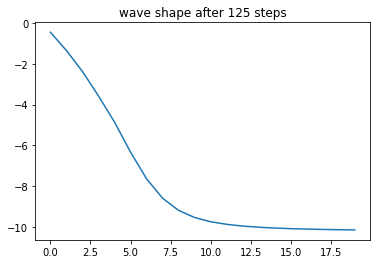

 25%|██▌       | 126/500 [01:46<05:46,  1.08it/s]

Training Step: 126
generator loss:1.243006438541687
-----------------------


 25%|██▌       | 127/500 [01:47<05:35,  1.11it/s]

total discriminator loss:0.34906182735668384
average true return:0.48805624971804623
-----------------------
Training Step: 127
generator loss:1.2483786311245408
-----------------------


 26%|██▌       | 128/500 [01:48<05:26,  1.14it/s]

total discriminator loss:0.3483703607248566
average true return:0.4886497497687861
-----------------------
Training Step: 128
generator loss:1.2538007530617497
-----------------------


 26%|██▌       | 129/500 [01:49<05:19,  1.16it/s]

total discriminator loss:0.34766171597026485
average true return:0.4892519759890307
-----------------------
Training Step: 129
generator loss:1.2593685717320482
-----------------------


 26%|██▌       | 130/500 [01:49<05:14,  1.18it/s]

total discriminator loss:0.3509069284582702
average true return:0.4901413025820742
-----------------------
Training Step: 130
generator loss:1.2645915254554043
-----------------------


 26%|██▌       | 131/500 [01:50<05:11,  1.19it/s]

total discriminator loss:0.3495569533220576
average true return:0.4906283184843599
-----------------------
Training Step: 131
generator loss:1.2698969660297483
-----------------------


 26%|██▋       | 132/500 [01:51<05:08,  1.19it/s]

total discriminator loss:0.35239772630033817
average true return:0.4916828842172187
-----------------------
Training Step: 132
generator loss:1.2754556452183947
-----------------------


 27%|██▋       | 133/500 [01:52<05:05,  1.20it/s]

total discriminator loss:0.3473412153545729
average true return:0.4921815303659335
-----------------------
Training Step: 133
generator loss:1.2798259381387695
-----------------------


 27%|██▋       | 134/500 [01:53<05:04,  1.20it/s]

total discriminator loss:0.32864553845466116
average true return:0.49302553133968036
-----------------------
Training Step: 134
generator loss:1.283884142894403
-----------------------


 27%|██▋       | 135/500 [01:53<05:02,  1.21it/s]

total discriminator loss:0.3514031399617603
average true return:0.4936957493129956
-----------------------
Training Step: 135
generator loss:1.2879126367732703
-----------------------


 27%|██▋       | 136/500 [01:54<05:01,  1.21it/s]

total discriminator loss:0.3434961743985945
average true return:0.49412525093233195
-----------------------
Training Step: 136
generator loss:1.291919369545034
-----------------------


 27%|██▋       | 137/500 [01:55<05:00,  1.21it/s]

total discriminator loss:0.33361583486316837
average true return:0.4944904058987042
-----------------------
Training Step: 137
generator loss:1.294937318425114
-----------------------


 28%|██▊       | 138/500 [01:56<04:58,  1.21it/s]

total discriminator loss:0.34194004784616383
average true return:0.4952940106211541
-----------------------
Training Step: 138
generator loss:1.2971785508050082
-----------------------


 28%|██▊       | 139/500 [01:57<04:57,  1.21it/s]

total discriminator loss:0.351630883251921
average true return:0.4956886811120328
-----------------------
Training Step: 139
generator loss:1.2988844369314956
-----------------------


 28%|██▊       | 140/500 [01:58<04:56,  1.21it/s]

total discriminator loss:0.3444672106791547
average true return:0.49643466093795446
-----------------------
Training Step: 140
generator loss:1.2996828949198822
-----------------------


 28%|██▊       | 141/500 [01:58<04:55,  1.21it/s]

total discriminator loss:0.37662735087397436
average true return:0.49695173182139346
-----------------------
Training Step: 141
generator loss:1.3011909558049215
-----------------------


 28%|██▊       | 142/500 [01:59<04:54,  1.22it/s]

total discriminator loss:0.3637705531529035
average true return:0.4976997483719494
-----------------------
Training Step: 142
generator loss:1.302214037215307
-----------------------


 29%|██▊       | 143/500 [02:00<04:53,  1.22it/s]

total discriminator loss:0.3460711726958564
average true return:0.4979999660501484
-----------------------
Training Step: 143
generator loss:1.3021910145015947
-----------------------


 29%|██▉       | 144/500 [02:01<04:53,  1.21it/s]

total discriminator loss:0.3317896481701728
average true return:0.4983737534563992
-----------------------
Training Step: 144
generator loss:1.303644142192509
-----------------------


 29%|██▉       | 145/500 [02:02<04:52,  1.21it/s]

total discriminator loss:0.3360654257096235
average true return:0.4986525264779235
-----------------------
Training Step: 145
generator loss:1.3049690265568321
-----------------------


 29%|██▉       | 146/500 [02:03<04:51,  1.21it/s]

total discriminator loss:0.3085217582040154
average true return:0.49878643916099463
-----------------------
Training Step: 146
generator loss:1.3076473915953066
-----------------------


 29%|██▉       | 147/500 [02:03<04:50,  1.21it/s]

total discriminator loss:0.32081284657729403
average true return:0.49891427855595666
-----------------------
Training Step: 147
generator loss:1.3101284046901098
-----------------------


 30%|██▉       | 148/500 [02:04<04:49,  1.21it/s]

total discriminator loss:0.33405065005412327
average true return:0.49845364993607577
-----------------------
Training Step: 148
generator loss:1.3139181342656812
-----------------------


 30%|██▉       | 149/500 [02:05<04:48,  1.22it/s]

total discriminator loss:0.3578132229156234
average true return:0.49831514644578145
-----------------------
Training Step: 149
generator loss:1.318819431749815
-----------------------


 30%|███       | 150/500 [02:06<04:57,  1.18it/s]

total discriminator loss:0.34116411436949845
average true return:0.49724255915844595
-----------------------
Training Step: 150
generator loss:1.3291571783156693
-----------------------
total discriminator loss:0.33134117437126753
average true return:0.49597183074531226
-----------------------
tf.Tensor([[1 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 20), dtype=int64)


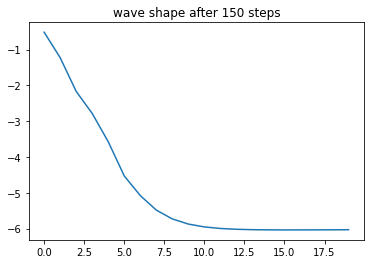

 30%|███       | 151/500 [02:07<05:26,  1.07it/s]

Training Step: 151
generator loss:1.3633451728482247
-----------------------


 30%|███       | 152/500 [02:08<05:16,  1.10it/s]

total discriminator loss:0.33932320082516976
average true return:0.489703785327839
-----------------------
Training Step: 152
generator loss:1.4600746682577823
-----------------------


 31%|███       | 153/500 [02:09<05:06,  1.13it/s]

total discriminator loss:0.33040071912716595
average true return:0.4822375961840203
-----------------------
Training Step: 153
generator loss:1.4972155753441259
-----------------------


 31%|███       | 154/500 [02:10<04:58,  1.16it/s]

total discriminator loss:0.35686792997824635
average true return:0.48222123970109504
-----------------------
Training Step: 154
generator loss:1.483181900420972
-----------------------


 31%|███       | 155/500 [02:10<04:53,  1.18it/s]

total discriminator loss:2.2715665369132623
average true return:0.4831078287484846
-----------------------
Training Step: 155
generator loss:1.4377888798898912
-----------------------


 31%|███       | 156/500 [02:11<04:50,  1.19it/s]

total discriminator loss:2.230782654230514
average true return:0.4849206338696306
-----------------------
Training Step: 156
generator loss:1.3654268540794914
-----------------------


 31%|███▏      | 157/500 [02:12<04:47,  1.19it/s]

total discriminator loss:0.34431465860588145
average true return:0.4877718560487144
-----------------------
Training Step: 157
generator loss:1.2920858051570898
-----------------------


 32%|███▏      | 158/500 [02:13<04:45,  1.20it/s]

total discriminator loss:0.3421110707126711
average true return:0.4916532434230376
-----------------------
Training Step: 158
generator loss:1.2223559164131155
-----------------------


 32%|███▏      | 159/500 [02:14<04:43,  1.20it/s]

total discriminator loss:0.33913263977079733
average true return:0.49653346438585827
-----------------------
Training Step: 159
generator loss:1.1611365998915737
-----------------------


 32%|███▏      | 160/500 [02:14<04:41,  1.21it/s]

total discriminator loss:0.3278568526685866
average true return:0.5005556486970243
-----------------------
Training Step: 160
generator loss:1.1127320433351606
-----------------------


 32%|███▏      | 161/500 [02:15<04:40,  1.21it/s]

total discriminator loss:0.3197163535660038
average true return:0.5040439453781371
-----------------------
Training Step: 161
generator loss:1.07317019106046
-----------------------


 32%|███▏      | 162/500 [02:16<04:39,  1.21it/s]

total discriminator loss:0.36287498006644014
average true return:0.5066642554066655
-----------------------
Training Step: 162
generator loss:1.0432699709538917
-----------------------


 33%|███▎      | 163/500 [02:17<04:48,  1.17it/s]

total discriminator loss:1.7810940294523965
average true return:0.5091899502560862
-----------------------
Training Step: 163
generator loss:0.9872943246323725
-----------------------


 33%|███▎      | 164/500 [02:18<04:45,  1.18it/s]

total discriminator loss:0.34973265157116074
average true return:0.5141707555161896
-----------------------
Training Step: 164
generator loss:0.9430573308141625
-----------------------


 33%|███▎      | 165/500 [02:19<04:41,  1.19it/s]

total discriminator loss:0.3574815020273142
average true return:0.5178690791977829
-----------------------
Training Step: 165
generator loss:0.9136682482256755
-----------------------


 33%|███▎      | 166/500 [02:20<04:39,  1.19it/s]

total discriminator loss:0.36606119619625044
average true return:0.5203284179332914
-----------------------
Training Step: 166
generator loss:0.8916154421173559
-----------------------


 33%|███▎      | 167/500 [02:20<04:37,  1.20it/s]

total discriminator loss:0.357480282887192
average true return:0.5213706162942983
-----------------------
Training Step: 167
generator loss:0.881746451275759
-----------------------


 34%|███▎      | 168/500 [02:21<04:35,  1.20it/s]

total discriminator loss:0.3648576093236242
average true return:0.5213394694093558
-----------------------
Training Step: 168
generator loss:0.8748666415055293
-----------------------


 34%|███▍      | 169/500 [02:22<04:35,  1.20it/s]

total discriminator loss:0.36265957065250015
average true return:0.5203268359245684
-----------------------
Training Step: 169
generator loss:0.8728695833045982
-----------------------


 34%|███▍      | 170/500 [02:23<04:33,  1.21it/s]

total discriminator loss:0.3763972134722413
average true return:0.5181025883899144
-----------------------
Training Step: 170
generator loss:0.8745148448077404
-----------------------


 34%|███▍      | 171/500 [02:24<04:37,  1.19it/s]

total discriminator loss:0.3696237164609154
average true return:0.5160878182095481
-----------------------
Training Step: 171
generator loss:0.8807858363540413
-----------------------


 34%|███▍      | 172/500 [02:25<04:36,  1.19it/s]

total discriminator loss:0.37415516893823475
average true return:0.5142543966744879
-----------------------
Training Step: 172
generator loss:0.8896564950689643
-----------------------


 35%|███▍      | 173/500 [02:25<04:37,  1.18it/s]

total discriminator loss:0.37430434764613085
average true return:0.5119220143361007
-----------------------
Training Step: 173
generator loss:0.8914112126144835
-----------------------


 35%|███▍      | 174/500 [02:26<04:38,  1.17it/s]

total discriminator loss:0.3910430571339012
average true return:0.5105406282004346
-----------------------
Training Step: 174
generator loss:0.9036179196512828
-----------------------


 35%|███▌      | 175/500 [02:27<04:45,  1.14it/s]

total discriminator loss:0.3859721738942586
average true return:0.5082535095701366
-----------------------
Training Step: 175
generator loss:0.9135928790262688
-----------------------
total discriminator loss:0.3515162241929976
average true return:0.5049780868945923
-----------------------
tf.Tensor([[2 0 2 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 20), dtype=int64)


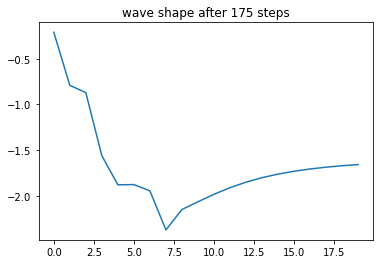

 35%|███▌      | 176/500 [02:28<05:18,  1.02it/s]

Training Step: 176
generator loss:0.9207304384614312
-----------------------


 35%|███▌      | 177/500 [02:29<05:12,  1.03it/s]

total discriminator loss:0.3614626009464599
average true return:0.504295775204217
-----------------------
Training Step: 177
generator loss:0.9329237657238738
-----------------------


 36%|███▌      | 178/500 [02:30<05:08,  1.04it/s]

total discriminator loss:0.37092791934618696
average true return:0.5022023512675376
-----------------------
Training Step: 178
generator loss:0.9459403210342908
-----------------------


 36%|███▌      | 179/500 [02:31<05:06,  1.05it/s]

total discriminator loss:0.3515198634614439
average true return:0.49940410076410474
-----------------------
Training Step: 179
generator loss:0.9588296723830148
-----------------------


 36%|███▌      | 180/500 [02:32<04:52,  1.09it/s]

total discriminator loss:0.3591274530097972
average true return:0.4982623702553628
-----------------------
Training Step: 180
generator loss:0.9696314156043223
-----------------------


 36%|███▌      | 181/500 [02:33<04:43,  1.13it/s]

total discriminator loss:0.3486340766955962
average true return:0.49567154913171413
-----------------------
Training Step: 181
generator loss:0.9799965461227764
-----------------------


 36%|███▋      | 182/500 [02:34<04:55,  1.08it/s]

total discriminator loss:0.3391448529620009
average true return:0.49555473583272713
-----------------------
Training Step: 182
generator loss:0.9889540233820596
-----------------------


 37%|███▋      | 183/500 [02:35<04:46,  1.11it/s]

total discriminator loss:0.35537271669348536
average true return:0.49407324499569083
-----------------------
Training Step: 183
generator loss:0.9890307657390007
-----------------------


 37%|███▋      | 184/500 [02:36<04:41,  1.12it/s]

total discriminator loss:0.32242400555676853
average true return:0.495725216457063
-----------------------
Training Step: 184
generator loss:1.0017549902919978
-----------------------


 37%|███▋      | 185/500 [02:37<04:36,  1.14it/s]

total discriminator loss:0.352409752865004
average true return:0.4946400977232253
-----------------------
Training Step: 185
generator loss:1.0113183670346786
-----------------------


 37%|███▋      | 186/500 [02:37<04:31,  1.16it/s]

total discriminator loss:0.3535791750697238
average true return:0.4939849658386706
-----------------------
Training Step: 186
generator loss:1.0204183838217902
-----------------------


 37%|███▋      | 187/500 [02:38<04:33,  1.14it/s]

total discriminator loss:0.3572298809556938
average true return:0.49387906702249174
-----------------------
Training Step: 187
generator loss:1.028616733606777
-----------------------


 38%|███▊      | 188/500 [02:39<04:34,  1.14it/s]

total discriminator loss:0.3154502317250252
average true return:0.49325561493567127
-----------------------
Training Step: 188
generator loss:1.034705102789625
-----------------------


 38%|███▊      | 189/500 [02:40<04:32,  1.14it/s]

total discriminator loss:0.35987542404595985
average true return:0.4935485307432212
-----------------------
Training Step: 189
generator loss:1.0416108307546974
-----------------------


 38%|███▊      | 190/500 [02:41<04:30,  1.15it/s]

total discriminator loss:0.37329870260449677
average true return:0.4937610523294987
-----------------------
Training Step: 190
generator loss:1.0503816600109626
-----------------------


 38%|███▊      | 191/500 [02:42<04:29,  1.15it/s]

total discriminator loss:0.33359343814070685
average true return:0.49335691838508405
-----------------------
Training Step: 191
generator loss:1.055405888637396
-----------------------


 38%|███▊      | 192/500 [02:43<04:27,  1.15it/s]

total discriminator loss:0.3346074254935142
average true return:0.4940335680793687
-----------------------
Training Step: 192
generator loss:1.0603611597026283
-----------------------


 39%|███▊      | 193/500 [02:43<04:27,  1.15it/s]

total discriminator loss:0.317298616062438
average true return:0.4941033259030543
-----------------------
Training Step: 193
generator loss:1.063322265206156
-----------------------


 39%|███▉      | 194/500 [02:44<04:25,  1.15it/s]

total discriminator loss:0.3588354202103964
average true return:0.4950147851103003
-----------------------
Training Step: 194
generator loss:1.068761870062891
-----------------------


 39%|███▉      | 195/500 [02:45<04:22,  1.16it/s]

total discriminator loss:0.3462496579383241
average true return:0.49510951966642214
-----------------------
Training Step: 195
generator loss:1.072677712976728
-----------------------


 39%|███▉      | 196/500 [02:46<04:29,  1.13it/s]

total discriminator loss:0.35309123543388543
average true return:0.4958114355587042
-----------------------
Training Step: 196
generator loss:1.071156255382903
-----------------------


 39%|███▉      | 197/500 [02:47<04:22,  1.15it/s]

total discriminator loss:0.33504445646247843
average true return:0.497481252896916
-----------------------
Training Step: 197
generator loss:1.071682551912846
-----------------------


 40%|███▉      | 198/500 [02:48<04:17,  1.17it/s]

total discriminator loss:0.3389114780117004
average true return:0.49825207992509546
-----------------------
Training Step: 198
generator loss:1.0713701295347808
-----------------------


 40%|███▉      | 199/500 [02:49<04:13,  1.19it/s]

total discriminator loss:0.3328337056299634
average true return:0.49929750658145144
-----------------------
Training Step: 199
generator loss:1.0725491553147881
-----------------------


 40%|████      | 200/500 [02:49<04:10,  1.20it/s]

total discriminator loss:0.3624754074132751
average true return:0.5002152997645615
-----------------------
Training Step: 200
generator loss:1.0723501914065876
-----------------------
total discriminator loss:0.34207183674750663
average true return:0.501780719914622
-----------------------
tf.Tensor([[1 3 1 2 0 3 0 0 0 0 0 2 2 0 0 0 2 0 0 0]], shape=(1, 20), dtype=int64)


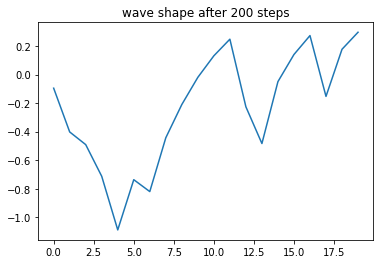

 40%|████      | 201/500 [02:51<04:36,  1.08it/s]

Training Step: 201
generator loss:1.0688585520322638
-----------------------


 40%|████      | 202/500 [02:51<04:27,  1.12it/s]

total discriminator loss:0.34186401288606916
average true return:0.5029632754083377
-----------------------
Training Step: 202
generator loss:1.0629602413868353
-----------------------


 41%|████      | 203/500 [02:52<04:19,  1.14it/s]

total discriminator loss:0.34633713339950967
average true return:0.5039753368772667
-----------------------
Training Step: 203
generator loss:1.0599300324505778
-----------------------


 41%|████      | 204/500 [02:53<04:14,  1.16it/s]

total discriminator loss:0.3283978908647287
average true return:0.5059487747719172
-----------------------
Training Step: 204
generator loss:1.0588453276201975
-----------------------


 41%|████      | 205/500 [02:54<04:10,  1.18it/s]

total discriminator loss:0.362978124881687
average true return:0.5073440448778878
-----------------------
Training Step: 205
generator loss:1.0509593813926768
-----------------------


 41%|████      | 206/500 [02:55<04:06,  1.19it/s]

total discriminator loss:0.3298041878407475
average true return:0.5085963259829401
-----------------------
Training Step: 206
generator loss:1.0482919712776755
-----------------------


 41%|████▏     | 207/500 [02:55<04:04,  1.20it/s]

total discriminator loss:0.333333630757664
average true return:0.5099521645736438
-----------------------
Training Step: 207
generator loss:1.04102046400876
-----------------------


 42%|████▏     | 208/500 [02:56<04:03,  1.20it/s]

total discriminator loss:0.34269705255453997
average true return:0.5116886733081829
-----------------------
Training Step: 208
generator loss:1.035206030431044
-----------------------


 42%|████▏     | 209/500 [02:57<04:02,  1.20it/s]

total discriminator loss:0.3531550094509128
average true return:0.5137282920924563
-----------------------
Training Step: 209
generator loss:1.0241449871102952
-----------------------


 42%|████▏     | 210/500 [02:58<04:06,  1.18it/s]

total discriminator loss:0.3243479694313721
average true return:0.5163032724285885
-----------------------
Training Step: 210
generator loss:1.0074960799433388
-----------------------


 42%|████▏     | 211/500 [02:59<04:02,  1.19it/s]

total discriminator loss:0.3343950382203945
average true return:0.5197682630680812
-----------------------
Training Step: 211
generator loss:0.9989389731333584
-----------------------


 42%|████▏     | 212/500 [03:00<04:05,  1.17it/s]

total discriminator loss:0.3315665388428732
average true return:0.5208021236437067
-----------------------
Training Step: 212
generator loss:1.0238894988898632
-----------------------


 43%|████▎     | 213/500 [03:01<04:04,  1.18it/s]

total discriminator loss:0.3310356548716976
average true return:0.5081039817624815
-----------------------
Training Step: 213
generator loss:1.157226965888562
-----------------------


 43%|████▎     | 214/500 [03:01<04:08,  1.15it/s]

total discriminator loss:0.3294904777254455
average true return:0.49404272494516915
-----------------------
Training Step: 214
generator loss:1.2231742353163924
-----------------------


 43%|████▎     | 215/500 [03:02<04:06,  1.16it/s]

total discriminator loss:0.3097283478028417
average true return:0.4866481254355875
-----------------------
Training Step: 215
generator loss:1.2521418710486976
-----------------------


 43%|████▎     | 216/500 [03:03<04:11,  1.13it/s]

total discriminator loss:0.3260917564009187
average true return:0.48586283365233773
-----------------------
Training Step: 216
generator loss:1.2548785669453046
-----------------------


 43%|████▎     | 217/500 [03:04<04:06,  1.15it/s]

total discriminator loss:0.33786574892692045
average true return:0.48577495713965757
-----------------------
Training Step: 217
generator loss:1.2502267611986668
-----------------------


 44%|████▎     | 218/500 [03:05<04:06,  1.14it/s]

total discriminator loss:2.046116804461635
average true return:0.48617801118659004
-----------------------
Training Step: 218
generator loss:1.232868396752549
-----------------------


 44%|████▍     | 219/500 [03:06<04:08,  1.13it/s]

total discriminator loss:2.038315223386915
average true return:0.48701108293548206
-----------------------
Training Step: 219
generator loss:1.200924152337489
-----------------------


 44%|████▍     | 220/500 [03:07<04:05,  1.14it/s]

total discriminator loss:0.3235504505590544
average true return:0.4883306649307275
-----------------------
Training Step: 220
generator loss:1.1772371574319165
-----------------------


 44%|████▍     | 221/500 [03:08<04:00,  1.16it/s]

total discriminator loss:0.3285361677883511
average true return:0.4899265725114089
-----------------------
Training Step: 221
generator loss:1.1473782361723055
-----------------------


 44%|████▍     | 222/500 [03:08<04:01,  1.15it/s]

total discriminator loss:0.3304955526828038
average true return:0.4911138894415359
-----------------------
Training Step: 222
generator loss:1.1258701125786346
-----------------------


 45%|████▍     | 223/500 [03:09<04:01,  1.15it/s]

total discriminator loss:0.32373190998920265
average true return:0.4925264836114021
-----------------------
Training Step: 223
generator loss:1.1040643079083927
-----------------------


 45%|████▍     | 224/500 [03:10<04:05,  1.12it/s]

total discriminator loss:0.33630418956062946
average true return:0.4936686145065402
-----------------------
Training Step: 224
generator loss:1.0878157616980269
-----------------------


 45%|████▌     | 225/500 [03:11<04:04,  1.13it/s]

total discriminator loss:0.3399539883062534
average true return:0.49489560973499896
-----------------------
Training Step: 225
generator loss:1.0749995736244313
-----------------------
total discriminator loss:0.3548005730752403
average true return:0.49548451861712334
-----------------------
tf.Tensor([[1 0 2 0 2 2 0 2 2 2 0 2 2 2 2 2 2 2 1 0]], shape=(1, 20), dtype=int64)


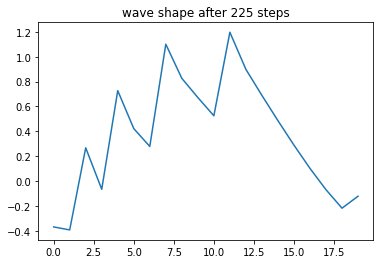

 45%|████▌     | 226/500 [03:12<04:27,  1.02it/s]

Training Step: 226
generator loss:1.0646747862754058
-----------------------


 45%|████▌     | 227/500 [03:13<04:22,  1.04it/s]

total discriminator loss:0.3225869726752037
average true return:0.4966135020565033
-----------------------
Training Step: 227
generator loss:1.053081591764852
-----------------------


 46%|████▌     | 228/500 [03:14<04:16,  1.06it/s]

total discriminator loss:0.32288281909519856
average true return:0.4973958782548918
-----------------------
Training Step: 228
generator loss:1.0440225649630728
-----------------------


 46%|████▌     | 229/500 [03:15<04:12,  1.07it/s]

total discriminator loss:0.33449803000270917
average true return:0.4988609926126346
-----------------------
Training Step: 229
generator loss:1.035438499281363
-----------------------


 46%|████▌     | 230/500 [03:16<04:04,  1.10it/s]

total discriminator loss:0.31023893675884096
average true return:0.4993681482662433
-----------------------
Training Step: 230
generator loss:1.030483273326963
-----------------------


 46%|████▌     | 231/500 [03:17<03:59,  1.13it/s]

total discriminator loss:0.3345034711387823
average true return:0.499860271678674
-----------------------
Training Step: 231
generator loss:1.0237928291668714
-----------------------


 46%|████▋     | 232/500 [03:18<03:58,  1.13it/s]

total discriminator loss:0.33938743074872435
average true return:0.5006514440955998
-----------------------
Training Step: 232
generator loss:1.0231158419947732
-----------------------


 47%|████▋     | 233/500 [03:18<03:51,  1.15it/s]

total discriminator loss:1.7160499442001775
average true return:0.5018995875276364
-----------------------
Training Step: 233
generator loss:1.0113067457322873
-----------------------


 47%|████▋     | 234/500 [03:19<03:47,  1.17it/s]

total discriminator loss:0.3337299086720934
average true return:0.502183288943616
-----------------------
Training Step: 234
generator loss:0.999578670691851
-----------------------


 47%|████▋     | 235/500 [03:20<03:48,  1.16it/s]

total discriminator loss:0.3611653197838888
average true return:0.502596379473562
-----------------------
Training Step: 235
generator loss:0.9917549656562453
-----------------------


 47%|████▋     | 236/500 [03:21<03:45,  1.17it/s]

total discriminator loss:0.34153487492146545
average true return:0.5029864812809874
-----------------------
Training Step: 236
generator loss:0.9826882101819493
-----------------------


 47%|████▋     | 237/500 [03:22<03:45,  1.17it/s]

total discriminator loss:0.34096892286214964
average true return:0.5039966990186967
-----------------------
Training Step: 237
generator loss:0.9765469526524237
-----------------------


 48%|████▊     | 238/500 [03:23<03:42,  1.18it/s]

total discriminator loss:0.3501113043285353
average true return:0.504108701025147
-----------------------
Training Step: 238
generator loss:0.9723205022247283
-----------------------


 48%|████▊     | 239/500 [03:24<03:40,  1.19it/s]

total discriminator loss:0.3509146891353834
average true return:0.5034000288479776
-----------------------
Training Step: 239
generator loss:0.9721450559457737
-----------------------


 48%|████▊     | 240/500 [03:24<03:39,  1.18it/s]

total discriminator loss:0.3392544638348619
average true return:0.5037197696308229
-----------------------
Training Step: 240
generator loss:0.9753794120121653
-----------------------


 48%|████▊     | 241/500 [03:25<03:46,  1.15it/s]

total discriminator loss:0.3408137238824333
average true return:0.5031932071921624
-----------------------
Training Step: 241
generator loss:0.9762985693403929
-----------------------


 48%|████▊     | 242/500 [03:26<03:42,  1.16it/s]

total discriminator loss:0.33364454788322206
average true return:0.503052065384786
-----------------------
Training Step: 242
generator loss:0.9769002396277296
-----------------------


 49%|████▊     | 243/500 [03:27<03:39,  1.17it/s]

total discriminator loss:0.31929669450786646
average true return:0.5027744110651713
-----------------------
Training Step: 243
generator loss:0.9763830059392091
-----------------------


 49%|████▉     | 244/500 [03:28<03:35,  1.19it/s]

total discriminator loss:0.3296681936711673
average true return:0.5028553732045487
-----------------------
Training Step: 244
generator loss:0.976156411382818
-----------------------


 49%|████▉     | 245/500 [03:29<03:33,  1.19it/s]

total discriminator loss:0.33608050549196455
average true return:0.5019422252122312
-----------------------
Training Step: 245
generator loss:0.9859437695135757
-----------------------


 49%|████▉     | 246/500 [03:29<03:32,  1.19it/s]

total discriminator loss:0.3493840207429591
average true return:0.5012023184512332
-----------------------
Training Step: 246
generator loss:0.9860836792284182
-----------------------


 49%|████▉     | 247/500 [03:30<03:31,  1.20it/s]

total discriminator loss:0.33504480878955634
average true return:0.5007474093836157
-----------------------
Training Step: 247
generator loss:0.9920068298513778
-----------------------


 50%|████▉     | 248/500 [03:31<03:30,  1.20it/s]

total discriminator loss:0.33158894098778346
average true return:0.5007519308411916
-----------------------
Training Step: 248
generator loss:0.992829226532061
-----------------------


 50%|████▉     | 249/500 [03:32<03:30,  1.19it/s]

total discriminator loss:0.3337003274729685
average true return:0.5003067925236693
-----------------------
Training Step: 249
generator loss:1.0001474374653645
-----------------------


 50%|█████     | 250/500 [03:33<03:28,  1.20it/s]

total discriminator loss:0.35787065677846985
average true return:0.5003698338720877
-----------------------
Training Step: 250
generator loss:1.0067487524583818
-----------------------
total discriminator loss:0.31916317588723875
average true return:0.49974304208436376
-----------------------
tf.Tensor([[0 2 2 2 2 0 2 3 0 2 2 2 2 2 2 2 0 2 2 2]], shape=(1, 20), dtype=int64)


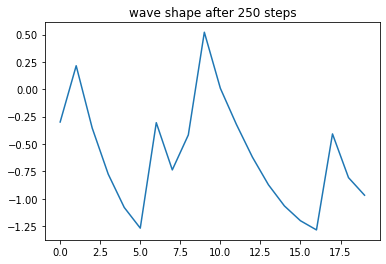

 50%|█████     | 251/500 [03:34<03:50,  1.08it/s]

Training Step: 251
generator loss:1.0111739729125353
-----------------------


 50%|█████     | 252/500 [03:35<03:42,  1.11it/s]

total discriminator loss:0.33123697715236416
average true return:0.5001503300877224
-----------------------
Training Step: 252
generator loss:1.0176676416823411
-----------------------


 51%|█████     | 253/500 [03:36<03:36,  1.14it/s]

total discriminator loss:0.33963219382437093
average true return:0.4989275963768146
-----------------------
Training Step: 253
generator loss:1.0226810783980076
-----------------------


 51%|█████     | 254/500 [03:36<03:32,  1.16it/s]

total discriminator loss:0.36649626846939043
average true return:0.4991722610993405
-----------------------
Training Step: 254
generator loss:1.0319505166423675
-----------------------


 51%|█████     | 255/500 [03:37<03:28,  1.18it/s]

total discriminator loss:0.3539956939010703
average true return:0.49787094571588475
-----------------------
Training Step: 255
generator loss:1.0392143054993361
-----------------------


 51%|█████     | 256/500 [03:38<03:25,  1.19it/s]

total discriminator loss:0.3244514206981962
average true return:0.4981797058510726
-----------------------
Training Step: 256
generator loss:1.040365645587725
-----------------------


 51%|█████▏    | 257/500 [03:39<03:22,  1.20it/s]

total discriminator loss:0.3464390895923861
average true return:0.4974467996502614
-----------------------
Training Step: 257
generator loss:1.0480139073050954
-----------------------


 52%|█████▏    | 258/500 [03:40<03:20,  1.20it/s]

total discriminator loss:0.3438214021204698
average true return:0.49721651786980403
-----------------------
Training Step: 258
generator loss:1.0553043368884398
-----------------------


 52%|█████▏    | 259/500 [03:41<03:19,  1.21it/s]

total discriminator loss:0.32687861586907996
average true return:0.49682074004157556
-----------------------
Training Step: 259
generator loss:1.0599630745317938
-----------------------


 52%|█████▏    | 260/500 [03:41<03:17,  1.21it/s]

total discriminator loss:0.32336711473725754
average true return:0.4969723250055038
-----------------------
Training Step: 260
generator loss:1.068695659950495
-----------------------


 52%|█████▏    | 261/500 [03:42<03:16,  1.22it/s]

total discriminator loss:0.3402457951321633
average true return:0.49725538757124643
-----------------------
Training Step: 261
generator loss:1.0702150949316453
-----------------------


 52%|█████▏    | 262/500 [03:43<03:15,  1.22it/s]

total discriminator loss:0.35644373776530186
average true return:0.49646330571815395
-----------------------
Training Step: 262
generator loss:1.0741965544832515
-----------------------


 53%|█████▎    | 263/500 [03:44<03:15,  1.21it/s]

total discriminator loss:0.3388438970324883
average true return:0.49751785847606433
-----------------------
Training Step: 263
generator loss:1.0756837801236787
-----------------------


 53%|█████▎    | 264/500 [03:45<03:14,  1.22it/s]

total discriminator loss:0.3086711245404573
average true return:0.497169398316616
-----------------------
Training Step: 264
generator loss:1.0832850917893153
-----------------------


 53%|█████▎    | 265/500 [03:45<03:12,  1.22it/s]

total discriminator loss:0.3234676334404571
average true return:0.4972422527457484
-----------------------
Training Step: 265
generator loss:1.0921989087799076
-----------------------


 53%|█████▎    | 266/500 [03:46<03:12,  1.22it/s]

total discriminator loss:0.3266900980368542
average true return:0.4976876791064214
-----------------------
Training Step: 266
generator loss:1.0976932117089149
-----------------------


 53%|█████▎    | 267/500 [03:47<03:17,  1.18it/s]

total discriminator loss:0.32279474447578804
average true return:0.49705814857024344
-----------------------
Training Step: 267
generator loss:1.1038593273871669
-----------------------


 54%|█████▎    | 268/500 [03:48<03:14,  1.19it/s]

total discriminator loss:0.3491984826443614
average true return:0.49733059352147485
-----------------------
Training Step: 268
generator loss:1.1077867822875558
-----------------------


 54%|█████▍    | 269/500 [03:49<03:11,  1.20it/s]

total discriminator loss:0.3308234831195042
average true return:0.4962627156888536
-----------------------
Training Step: 269
generator loss:1.1171391314763373
-----------------------


 54%|█████▍    | 270/500 [03:50<03:10,  1.21it/s]

total discriminator loss:1.8788939708647134
average true return:0.49640744558439126
-----------------------
Training Step: 270
generator loss:1.1099325929973207
-----------------------


 54%|█████▍    | 271/500 [03:50<03:09,  1.21it/s]

total discriminator loss:0.3347511223477654
average true return:0.496406858536416
-----------------------
Training Step: 271
generator loss:1.101256936633896
-----------------------


 54%|█████▍    | 272/500 [03:51<03:07,  1.21it/s]

total discriminator loss:0.3414480583637708
average true return:0.49737019290237716
-----------------------
Training Step: 272
generator loss:1.0903924956277256
-----------------------


 55%|█████▍    | 273/500 [03:52<03:06,  1.21it/s]

total discriminator loss:0.3485781079255241
average true return:0.4978007885014307
-----------------------
Training Step: 273
generator loss:1.0833314180045568
-----------------------


 55%|█████▍    | 274/500 [03:53<03:06,  1.21it/s]

total discriminator loss:0.3335159888272856
average true return:0.49864751298384064
-----------------------
Training Step: 274
generator loss:1.0789967932609072
-----------------------


 55%|█████▌    | 275/500 [03:54<03:05,  1.22it/s]

total discriminator loss:0.32374517556857585
average true return:0.49918970235366333
-----------------------
Training Step: 275
generator loss:1.0747560091320594
-----------------------
total discriminator loss:1.8151752638803424
average true return:0.49964750793025803
-----------------------
tf.Tensor([[0 1 2 2 0 2 1 2 0 2 2 2 0 0 2 2 2 2 0 0]], shape=(1, 20), dtype=int64)


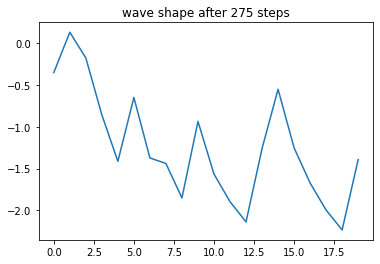

 55%|█████▌    | 276/500 [03:55<03:24,  1.09it/s]

Training Step: 276
generator loss:1.0614007142371957
-----------------------


 55%|█████▌    | 277/500 [03:56<03:18,  1.13it/s]

total discriminator loss:0.32773734900762486
average true return:0.5003139877589512
-----------------------
Training Step: 277
generator loss:1.0391748169796458
-----------------------


 56%|█████▌    | 278/500 [03:57<03:13,  1.15it/s]

total discriminator loss:0.3130492138083705
average true return:0.5019701678843553
-----------------------
Training Step: 278
generator loss:1.0235837096761282
-----------------------


 56%|█████▌    | 279/500 [03:57<03:08,  1.17it/s]

total discriminator loss:0.358021588561966
average true return:0.503223838860035
-----------------------
Training Step: 279
generator loss:1.011201967771954
-----------------------


 56%|█████▌    | 280/500 [03:58<03:05,  1.18it/s]

total discriminator loss:0.3461078603701515
average true return:0.5041164568337384
-----------------------
Training Step: 280
generator loss:0.9988805838906857
-----------------------


 56%|█████▌    | 281/500 [03:59<03:03,  1.19it/s]

total discriminator loss:0.33724463102322544
average true return:0.5052567105705208
-----------------------
Training Step: 281
generator loss:0.9912121898638584
-----------------------


 56%|█████▋    | 282/500 [04:00<03:00,  1.20it/s]

total discriminator loss:0.32661634933373745
average true return:0.5061815366988599
-----------------------
Training Step: 282
generator loss:0.9791150390608673
-----------------------


 57%|█████▋    | 283/500 [04:01<02:59,  1.21it/s]

total discriminator loss:0.34034586823952745
average true return:0.509015211660299
-----------------------
Training Step: 283
generator loss:0.9670102307968802
-----------------------


 57%|█████▋    | 284/500 [04:01<02:57,  1.22it/s]

total discriminator loss:0.3394703203340331
average true return:0.5125261201627274
-----------------------
Training Step: 284
generator loss:0.9455808992047486
-----------------------


 57%|█████▋    | 285/500 [04:02<02:56,  1.22it/s]

total discriminator loss:1.6225910868099358
average true return:0.5231982254121912
-----------------------
Training Step: 285
generator loss:0.802517625920796
-----------------------


 57%|█████▋    | 286/500 [04:03<02:55,  1.22it/s]

total discriminator loss:0.558375863117416
average true return:0.6433321464250233
-----------------------
Training Step: 286
generator loss:0.3993332353569066
-----------------------


 57%|█████▋    | 287/500 [04:04<03:00,  1.18it/s]

total discriminator loss:0.8717573932024757
average true return:0.7891801499984621
-----------------------
Training Step: 287
generator loss:0.23772168465273785
-----------------------


 58%|█████▊    | 288/500 [04:05<02:58,  1.19it/s]

total discriminator loss:0.9224957623624143
average true return:0.8009269099353569
-----------------------
Training Step: 288
generator loss:0.3182653892451031
-----------------------


 58%|█████▊    | 289/500 [04:06<02:55,  1.20it/s]

total discriminator loss:0.8166536482788757
average true return:0.7669629366628234
-----------------------
Training Step: 289
generator loss:0.42048142466072036
-----------------------


 58%|█████▊    | 290/500 [04:06<02:54,  1.20it/s]

total discriminator loss:0.6607160487357406
average true return:0.7009822689832759
-----------------------
Training Step: 290
generator loss:0.6295527774408178
-----------------------


 58%|█████▊    | 291/500 [04:07<02:54,  1.20it/s]

total discriminator loss:0.4212330974816083
average true return:0.5044958326593817
-----------------------
Training Step: 291
generator loss:1.7094367829335564
-----------------------


 58%|█████▊    | 292/500 [04:08<02:52,  1.20it/s]

total discriminator loss:0.3701776029824998
average true return:0.3874524352244082
-----------------------
Training Step: 292
generator loss:1.90846122182257
-----------------------


 59%|█████▊    | 293/500 [04:09<02:50,  1.21it/s]

total discriminator loss:1.153011775050457
average true return:0.10456165628569716
-----------------------
Training Step: 293
generator loss:2.7732378097733523
-----------------------


 59%|█████▉    | 294/500 [04:10<02:49,  1.22it/s]

total discriminator loss:1.3809615706547111
average true return:0.06392847443817778
-----------------------
Training Step: 294
generator loss:2.77099295437981
-----------------------


 59%|█████▉    | 295/500 [04:11<02:48,  1.22it/s]

total discriminator loss:1.3595544505678074
average true return:0.06511777361813748
-----------------------
Training Step: 295
generator loss:2.6912275764274183
-----------------------


 59%|█████▉    | 296/500 [04:11<02:47,  1.22it/s]

total discriminator loss:1.3200834569576516
average true return:0.07281063554584062
-----------------------
Training Step: 296
generator loss:2.5652042403705986
-----------------------


 59%|█████▉    | 297/500 [04:12<02:46,  1.22it/s]

total discriminator loss:1.2396417000889135
average true return:0.084043782421245
-----------------------
Training Step: 297
generator loss:2.423767680032192
-----------------------


 60%|█████▉    | 298/500 [04:13<02:46,  1.22it/s]

total discriminator loss:1.138478263558219
average true return:0.09959660374683307
-----------------------
Training Step: 298
generator loss:2.267141044677958
-----------------------


 60%|█████▉    | 299/500 [04:14<02:44,  1.22it/s]

total discriminator loss:1.07784864388155
average true return:0.12085940611317329
-----------------------
Training Step: 299
generator loss:2.1045396976701207
-----------------------


 60%|██████    | 300/500 [04:15<02:43,  1.22it/s]

total discriminator loss:0.9842939753100319
average true return:0.14645074266435426
-----------------------
Training Step: 300
generator loss:1.9443709225617847
-----------------------
total discriminator loss:0.8674236273238352
average true return:0.17843717196980782
-----------------------
tf.Tensor([[2 2 2 0 1 0 2 2 0 2 0 2 2 0 2 2 2 2 2 2]], shape=(1, 20), dtype=int64)


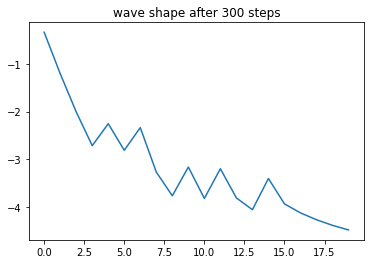

 60%|██████    | 301/500 [04:16<03:05,  1.07it/s]

Training Step: 301
generator loss:1.7949249624716144
-----------------------


 60%|██████    | 302/500 [04:17<02:58,  1.11it/s]

total discriminator loss:1.0441693518479986
average true return:0.21207484825818784
-----------------------
Training Step: 302
generator loss:1.6230137234369961
-----------------------


 61%|██████    | 303/500 [04:18<02:53,  1.14it/s]

total discriminator loss:0.7091040846519914
average true return:0.25657612692969933
-----------------------
Training Step: 303
generator loss:1.4573320727804435
-----------------------


 61%|██████    | 304/500 [04:18<02:48,  1.16it/s]

total discriminator loss:0.6622048044381664
average true return:0.30271942653185663
-----------------------
Training Step: 304
generator loss:1.3144324353655528
-----------------------


 61%|██████    | 305/500 [04:19<02:45,  1.18it/s]

total discriminator loss:0.5816181800379978
average true return:0.3568737897619405
-----------------------
Training Step: 305
generator loss:1.1550799113434853
-----------------------


 61%|██████    | 306/500 [04:20<02:42,  1.19it/s]

total discriminator loss:0.5172952121607353
average true return:0.43497370135204566
-----------------------
Training Step: 306
generator loss:0.9819250393781688
-----------------------


 61%|██████▏   | 307/500 [04:21<02:40,  1.20it/s]

total discriminator loss:0.4234474953747003
average true return:0.5394691121154442
-----------------------
Training Step: 307
generator loss:0.8267455999949818
-----------------------


 62%|██████▏   | 308/500 [04:22<02:39,  1.21it/s]

total discriminator loss:0.41236518708081793
average true return:0.597826752614248
-----------------------
Training Step: 308
generator loss:0.7520936519626067
-----------------------


 62%|██████▏   | 309/500 [04:22<02:37,  1.21it/s]

total discriminator loss:0.43936467113021127
average true return:0.6210679315202521
-----------------------
Training Step: 309
generator loss:0.7093937240334003
-----------------------


 62%|██████▏   | 310/500 [04:23<02:36,  1.21it/s]

total discriminator loss:0.4566575058809166
average true return:0.6361308362504727
-----------------------
Training Step: 310
generator loss:0.6913452565902127
-----------------------


 62%|██████▏   | 311/500 [04:24<02:35,  1.21it/s]

total discriminator loss:0.4521310930256058
average true return:0.6424764009308132
-----------------------
Training Step: 311
generator loss:0.6902455661669122
-----------------------


 62%|██████▏   | 312/500 [04:25<02:34,  1.22it/s]

total discriminator loss:0.4421553863027089
average true return:0.643336617594396
-----------------------
Training Step: 312
generator loss:0.699303428623436
-----------------------


 63%|██████▎   | 313/500 [04:26<02:34,  1.21it/s]

total discriminator loss:0.4197355003701356
average true return:0.640856072384453
-----------------------
Training Step: 313
generator loss:0.7090338135700375
-----------------------


 63%|██████▎   | 314/500 [04:27<02:33,  1.21it/s]

total discriminator loss:1.3771988750743254
average true return:0.639078797388329
-----------------------
Training Step: 314
generator loss:0.697264732631388
-----------------------


 63%|██████▎   | 315/500 [04:27<02:32,  1.22it/s]

total discriminator loss:0.4455092914741703
average true return:0.6406443685922336
-----------------------
Training Step: 315
generator loss:0.6958561047220854
-----------------------


 63%|██████▎   | 316/500 [04:28<02:31,  1.22it/s]

total discriminator loss:0.44147620695821405
average true return:0.6391943375884864
-----------------------
Training Step: 316
generator loss:0.6955602305236767
-----------------------


 63%|██████▎   | 317/500 [04:29<02:29,  1.22it/s]

total discriminator loss:0.45257099178254073
average true return:0.6368598849728814
-----------------------
Training Step: 317
generator loss:0.7003025694191788
-----------------------


 64%|██████▎   | 318/500 [04:30<02:29,  1.22it/s]

total discriminator loss:0.46398611937100454
average true return:0.6325823771139303
-----------------------
Training Step: 318
generator loss:0.7074991650161994
-----------------------


 64%|██████▍   | 319/500 [04:31<02:28,  1.22it/s]

total discriminator loss:0.4251107652330926
average true return:0.6267099148706672
-----------------------
Training Step: 319
generator loss:0.7185591374201472
-----------------------


 64%|██████▍   | 320/500 [04:31<02:27,  1.22it/s]

total discriminator loss:0.4329465558793372
average true return:0.6208497129213375
-----------------------
Training Step: 320
generator loss:0.7277790734467559
-----------------------


 64%|██████▍   | 321/500 [04:32<02:27,  1.22it/s]

total discriminator loss:0.43119497112438343
average true return:0.615373230763967
-----------------------
Training Step: 321
generator loss:0.7363229657605694
-----------------------


 64%|██████▍   | 322/500 [04:33<02:26,  1.22it/s]

total discriminator loss:0.4341011790666669
average true return:0.6037417463267742
-----------------------
Training Step: 322
generator loss:0.7471109651001755
-----------------------


 65%|██████▍   | 323/500 [04:34<02:25,  1.22it/s]

total discriminator loss:0.4267081563435161
average true return:0.5957587201596255
-----------------------
Training Step: 323
generator loss:0.7544511089373376
-----------------------


 65%|██████▍   | 324/500 [04:35<02:24,  1.21it/s]

total discriminator loss:0.43818462344667536
average true return:0.5892315018253363
-----------------------
Training Step: 324
generator loss:0.7613282508367334
-----------------------


 65%|██████▌   | 325/500 [04:36<02:24,  1.21it/s]

total discriminator loss:0.44553321477611413
average true return:0.5847354399635865
-----------------------
Training Step: 325
generator loss:0.7572298789505323
-----------------------
total discriminator loss:0.4491757635921122
average true return:0.5805345102767983
-----------------------
tf.Tensor([[0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]], shape=(1, 20), dtype=int64)


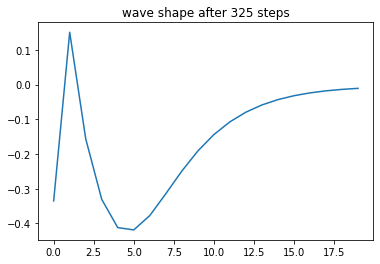

 65%|██████▌   | 326/500 [04:37<02:40,  1.08it/s]

Training Step: 326
generator loss:0.7425344789579884
-----------------------


 65%|██████▌   | 327/500 [04:38<02:34,  1.12it/s]

total discriminator loss:0.4622883851417656
average true return:0.5883855405457734
-----------------------
Training Step: 327
generator loss:0.6523406761791366
-----------------------


 66%|██████▌   | 328/500 [04:38<02:29,  1.15it/s]

total discriminator loss:0.5901330240833262
average true return:0.6523717747699485
-----------------------
Training Step: 328
generator loss:0.405601397478598
-----------------------


 66%|██████▌   | 329/500 [04:39<02:26,  1.17it/s]

total discriminator loss:0.8001535035529168
average true return:0.7484945663451512
-----------------------
Training Step: 329
generator loss:0.3617754719445414
-----------------------


 66%|██████▌   | 330/500 [04:40<02:23,  1.18it/s]

total discriminator loss:0.817947353085344
average true return:0.7269984528423885
-----------------------
Training Step: 330
generator loss:0.39344151285662865
-----------------------


 66%|██████▌   | 331/500 [04:41<02:21,  1.19it/s]

total discriminator loss:0.772336498673253
average true return:0.6914630915342673
-----------------------
Training Step: 331
generator loss:0.49424745409020254
-----------------------


 66%|██████▋   | 332/500 [04:42<02:20,  1.20it/s]

total discriminator loss:0.4553938247882001
average true return:0.4802853948533402
-----------------------
Training Step: 332
generator loss:1.303796975051224
-----------------------


 67%|██████▋   | 333/500 [04:42<02:18,  1.20it/s]

total discriminator loss:0.5906630775469703
average true return:0.29258744759842104
-----------------------
Training Step: 333
generator loss:1.919727554425835
-----------------------


 67%|██████▋   | 334/500 [04:43<02:16,  1.21it/s]

total discriminator loss:0.9989076771104922
average true return:0.16732468333090178
-----------------------
Training Step: 334
generator loss:1.7261664381503885
-----------------------


 67%|██████▋   | 335/500 [04:44<02:15,  1.22it/s]

total discriminator loss:0.9501400280806229
average true return:0.18988527662927696
-----------------------
Training Step: 335
generator loss:1.600618183502069
-----------------------


 67%|██████▋   | 336/500 [04:45<02:14,  1.22it/s]

total discriminator loss:0.8561572973797382
average true return:0.2537356746265903
-----------------------
Training Step: 336
generator loss:1.6757012158436595
-----------------------


 67%|██████▋   | 337/500 [04:46<02:13,  1.22it/s]

total discriminator loss:0.8000925246640597
average true return:0.3394253670914128
-----------------------
Training Step: 337
generator loss:1.6733774206574787
-----------------------


 68%|██████▊   | 338/500 [04:47<02:12,  1.22it/s]

total discriminator loss:0.7039664361628852
average true return:0.35919543234030016
-----------------------
Training Step: 338
generator loss:1.4981385153670987
-----------------------


 68%|██████▊   | 339/500 [04:47<02:11,  1.22it/s]

total discriminator loss:0.6047531231683592
average true return:0.3375110840923432
-----------------------
Training Step: 339
generator loss:1.3173260257668926
-----------------------


 68%|██████▊   | 340/500 [04:48<02:10,  1.22it/s]

total discriminator loss:0.6201452881517833
average true return:0.30746285795649947
-----------------------
Training Step: 340
generator loss:1.143988842745681
-----------------------


 68%|██████▊   | 341/500 [04:49<02:09,  1.22it/s]

total discriminator loss:0.9157261067897856
average true return:0.3176786724217885
-----------------------
Training Step: 341
generator loss:1.1627195235529393
-----------------------


 68%|██████▊   | 342/500 [04:50<02:09,  1.22it/s]

total discriminator loss:0.8921682682114183
average true return:0.37024854153960207
-----------------------
Training Step: 342
generator loss:1.1603153863008524
-----------------------


 69%|██████▊   | 343/500 [04:51<02:08,  1.22it/s]

total discriminator loss:0.6004179973415602
average true return:0.40825024684685374
-----------------------
Training Step: 343
generator loss:1.16127418807493
-----------------------


 69%|██████▉   | 344/500 [04:51<02:07,  1.23it/s]

total discriminator loss:0.5393713619928676
average true return:0.38583886064745787
-----------------------
Training Step: 344
generator loss:1.096755997248028
-----------------------


 69%|██████▉   | 345/500 [04:52<02:06,  1.22it/s]

total discriminator loss:0.7741636472995592
average true return:0.36651604242901714
-----------------------
Training Step: 345
generator loss:1.089669832997888
-----------------------


 69%|██████▉   | 346/500 [04:53<02:06,  1.22it/s]

total discriminator loss:0.7828398106059227
average true return:0.39373416687001084
-----------------------
Training Step: 346
generator loss:1.0949847365881582
-----------------------


 69%|██████▉   | 347/500 [04:54<02:05,  1.22it/s]

total discriminator loss:0.5224676231677776
average true return:0.460659700904605
-----------------------
Training Step: 347
generator loss:1.1293929727697762
-----------------------


 70%|██████▉   | 348/500 [04:55<02:04,  1.22it/s]

total discriminator loss:0.5522425721630029
average true return:0.3943175739278755
-----------------------
Training Step: 348
generator loss:1.0060903784828072
-----------------------


 70%|██████▉   | 349/500 [04:56<02:03,  1.22it/s]

total discriminator loss:0.7067642649478026
average true return:0.35390495188136756
-----------------------
Training Step: 349
generator loss:1.0541761374761904
-----------------------


 70%|███████   | 350/500 [04:56<02:07,  1.18it/s]

total discriminator loss:0.5595253560243907
average true return:0.4705006065081059
-----------------------
Training Step: 350
generator loss:1.223600529864128
-----------------------
total discriminator loss:0.5197621530560455
average true return:0.47286158538700024
-----------------------
tf.Tensor([[1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]], shape=(1, 20), dtype=int64)


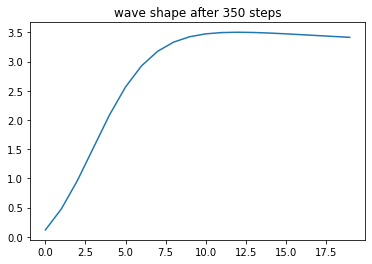

 70%|███████   | 351/500 [04:58<02:19,  1.07it/s]

Training Step: 351
generator loss:1.1751724396459848
-----------------------


 70%|███████   | 352/500 [04:58<02:13,  1.11it/s]

total discriminator loss:0.6201853716668192
average true return:0.38616320126837705
-----------------------
Training Step: 352
generator loss:1.1387221627248223
-----------------------


 71%|███████   | 353/500 [04:59<02:08,  1.14it/s]

total discriminator loss:0.5702637401495636
average true return:0.40695990415677585
-----------------------
Training Step: 353
generator loss:1.178326939141284
-----------------------


 71%|███████   | 354/500 [05:00<02:06,  1.16it/s]

total discriminator loss:1.0898602817242913
average true return:0.4816785003125883
-----------------------
Training Step: 354
generator loss:1.1627353983112818
-----------------------


 71%|███████   | 355/500 [05:01<02:03,  1.17it/s]

total discriminator loss:0.5148984706434483
average true return:0.4415961149274248
-----------------------
Training Step: 355
generator loss:1.1587799221161825
-----------------------


 71%|███████   | 356/500 [05:02<02:01,  1.18it/s]

total discriminator loss:0.5424109580521623
average true return:0.427350050176119
-----------------------
Training Step: 356
generator loss:1.1614074872373719
-----------------------


 71%|███████▏  | 357/500 [05:03<01:59,  1.20it/s]

total discriminator loss:0.48755689130568886
average true return:0.47806881844681715
-----------------------
Training Step: 357
generator loss:1.1202070640679351
-----------------------


 72%|███████▏  | 358/500 [05:03<01:57,  1.21it/s]

total discriminator loss:0.47775755568781236
average true return:0.47915495597083924
-----------------------
Training Step: 358
generator loss:1.089944024329374
-----------------------


 72%|███████▏  | 359/500 [05:04<01:56,  1.21it/s]

total discriminator loss:0.4944845295832173
average true return:0.4691068798695618
-----------------------
Training Step: 359
generator loss:1.0801589884526173
-----------------------


 72%|███████▏  | 360/500 [05:05<01:55,  1.21it/s]

total discriminator loss:0.48286912699061957
average true return:0.48103184724060544
-----------------------
Training Step: 360
generator loss:1.0354133568924753
-----------------------


 72%|███████▏  | 361/500 [05:06<01:54,  1.22it/s]

total discriminator loss:0.470237915095175
average true return:0.4998456829824269
-----------------------
Training Step: 361
generator loss:0.9876868348136388
-----------------------


 72%|███████▏  | 362/500 [05:07<01:53,  1.21it/s]

total discriminator loss:0.48458412374558113
average true return:0.5122203175421329
-----------------------
Training Step: 362
generator loss:0.9284307519062713
-----------------------


 73%|███████▎  | 363/500 [05:07<01:52,  1.22it/s]

total discriminator loss:0.49610786503998516
average true return:0.518191791754055
-----------------------
Training Step: 363
generator loss:0.8614034200042916
-----------------------


 73%|███████▎  | 364/500 [05:08<01:52,  1.21it/s]

total discriminator loss:0.49022724890009756
average true return:0.5436120531037634
-----------------------
Training Step: 364
generator loss:0.8013076900635419
-----------------------


 73%|███████▎  | 365/500 [05:09<01:51,  1.21it/s]

total discriminator loss:0.5244016408570902
average true return:0.5707161072147524
-----------------------
Training Step: 365
generator loss:0.7100473766830978
-----------------------


 73%|███████▎  | 366/500 [05:10<01:50,  1.22it/s]

total discriminator loss:0.9619056120645407
average true return:0.5993437017865122
-----------------------
Training Step: 366
generator loss:0.6136864508167508
-----------------------


 73%|███████▎  | 367/500 [05:11<01:49,  1.22it/s]

total discriminator loss:0.5970161019786755
average true return:0.6234544356409462
-----------------------
Training Step: 367
generator loss:0.5344921364136003
-----------------------


 74%|███████▎  | 368/500 [05:12<01:48,  1.22it/s]

total discriminator loss:0.6481523930369641
average true return:0.6488908023949287
-----------------------
Training Step: 368
generator loss:0.49787583759654697
-----------------------


 74%|███████▍  | 369/500 [05:12<01:47,  1.22it/s]

total discriminator loss:0.6545320297593087
average true return:0.6571333360340893
-----------------------
Training Step: 369
generator loss:0.48630755488048216
-----------------------


 74%|███████▍  | 370/500 [05:13<01:46,  1.22it/s]

total discriminator loss:0.6721741608198497
average true return:0.6544038956888572
-----------------------
Training Step: 370
generator loss:0.48895999445745875
-----------------------


 74%|███████▍  | 371/500 [05:14<01:45,  1.22it/s]

total discriminator loss:0.6450534941219286
average true return:0.6379333918430319
-----------------------
Training Step: 371
generator loss:0.5264116170468853
-----------------------


 74%|███████▍  | 372/500 [05:15<01:44,  1.22it/s]

total discriminator loss:0.6601565393618918
average true return:0.6189816711290674
-----------------------
Training Step: 372
generator loss:0.5460601010340046
-----------------------


 75%|███████▍  | 373/500 [05:16<01:44,  1.22it/s]

total discriminator loss:0.6744420134393749
average true return:0.5911298404251419
-----------------------
Training Step: 373
generator loss:0.582018068167629
-----------------------


 75%|███████▍  | 374/500 [05:16<01:43,  1.22it/s]

total discriminator loss:0.6855264036688388
average true return:0.5608943984112171
-----------------------
Training Step: 374
generator loss:0.639743839052346
-----------------------


 75%|███████▌  | 375/500 [05:17<01:42,  1.22it/s]

total discriminator loss:0.6964139893422382
average true return:0.5248765454239865
-----------------------
Training Step: 375
generator loss:0.6775856069511426
-----------------------
total discriminator loss:0.6970419249030088
average true return:0.5085857919708086
-----------------------
tf.Tensor([[3 1 1 3 3 0 1 0 2 2 2 1 1 2 3 1 0 3 1 1]], shape=(1, 20), dtype=int64)


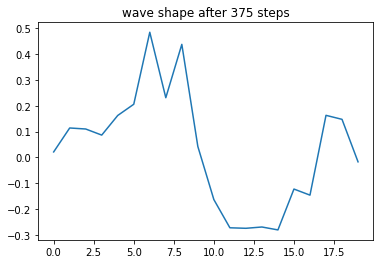

 75%|███████▌  | 376/500 [05:18<01:53,  1.09it/s]

Training Step: 376
generator loss:0.6996677828097099
-----------------------


 75%|███████▌  | 377/500 [05:19<01:49,  1.13it/s]

total discriminator loss:0.7277927887526237
average true return:0.48476719161280324
-----------------------
Training Step: 377
generator loss:0.7176140315959065
-----------------------


 76%|███████▌  | 378/500 [05:20<01:45,  1.15it/s]

total discriminator loss:0.6989049701045784
average true return:0.47386868607552945
-----------------------
Training Step: 378
generator loss:0.7279432781995979
-----------------------


 76%|███████▌  | 379/500 [05:21<01:43,  1.17it/s]

total discriminator loss:0.7250996268210892
average true return:0.4705546194224984
-----------------------
Training Step: 379
generator loss:0.7416424762970443
-----------------------


 76%|███████▌  | 380/500 [05:22<01:41,  1.19it/s]

total discriminator loss:0.7129268333264767
average true return:0.4587138502937108
-----------------------
Training Step: 380
generator loss:0.7470943801023546
-----------------------


 76%|███████▌  | 381/500 [05:23<01:39,  1.20it/s]

total discriminator loss:0.7017567964632403
average true return:0.46509179843397963
-----------------------
Training Step: 381
generator loss:0.7355053859289074
-----------------------


 76%|███████▋  | 382/500 [05:23<01:41,  1.16it/s]

total discriminator loss:0.7200532544304252
average true return:0.4547911274289742
-----------------------
Training Step: 382
generator loss:0.7451376059201957
-----------------------


 77%|███████▋  | 383/500 [05:24<01:39,  1.18it/s]

total discriminator loss:0.7209864852312706
average true return:0.46229031793992725
-----------------------
Training Step: 383
generator loss:0.7195774570001454
-----------------------


 77%|███████▋  | 384/500 [05:25<01:37,  1.19it/s]

total discriminator loss:0.701902120920695
average true return:0.4704689781589917
-----------------------
Training Step: 384
generator loss:0.7287225974552716
-----------------------


 77%|███████▋  | 385/500 [05:26<01:36,  1.20it/s]

total discriminator loss:0.7031190337523233
average true return:0.4676462914106869
-----------------------
Training Step: 385
generator loss:0.7037095046574692
-----------------------


 77%|███████▋  | 386/500 [05:27<01:35,  1.20it/s]

total discriminator loss:0.6920056047342378
average true return:0.480908412918769
-----------------------
Training Step: 386
generator loss:0.7139077134014408
-----------------------


 77%|███████▋  | 387/500 [05:28<01:34,  1.20it/s]

total discriminator loss:0.6971857554077412
average true return:0.47681043332487005
-----------------------
Training Step: 387
generator loss:0.7031467362448152
-----------------------


 78%|███████▊  | 388/500 [05:28<01:32,  1.20it/s]

total discriminator loss:0.7155821290301108
average true return:0.4833906633020396
-----------------------
Training Step: 388
generator loss:0.6929823986681964
-----------------------


 78%|███████▊  | 389/500 [05:29<01:31,  1.21it/s]

total discriminator loss:0.694649345808495
average true return:0.4916147101448985
-----------------------
Training Step: 389
generator loss:0.6889466515486002
-----------------------


 78%|███████▊  | 390/500 [05:30<01:30,  1.21it/s]

total discriminator loss:0.6902975392149575
average true return:0.48951522421201754
-----------------------
Training Step: 390
generator loss:0.6894936178975757
-----------------------


 78%|███████▊  | 391/500 [05:31<01:29,  1.22it/s]

total discriminator loss:0.7497077640685142
average true return:0.4886397422858838
-----------------------
Training Step: 391
generator loss:0.685999350649086
-----------------------


 78%|███████▊  | 392/500 [05:32<01:28,  1.22it/s]

total discriminator loss:0.6910165767192962
average true return:0.4915764019625539
-----------------------
Training Step: 392
generator loss:0.693903426618804
-----------------------


 79%|███████▊  | 393/500 [05:32<01:27,  1.22it/s]

total discriminator loss:0.6985413705877155
average true return:0.49306070155718396
-----------------------
Training Step: 393
generator loss:0.6863744771047248
-----------------------


 79%|███████▉  | 394/500 [05:33<01:27,  1.22it/s]

total discriminator loss:0.7036414772172465
average true return:0.4998737482201542
-----------------------
Training Step: 394
generator loss:0.6714454645292516
-----------------------


 79%|███████▉  | 395/500 [05:34<01:26,  1.22it/s]

total discriminator loss:0.7496734990538203
average true return:0.4873310648670335
-----------------------
Training Step: 395
generator loss:0.6782004072499241
-----------------------


 79%|███████▉  | 396/500 [05:35<01:28,  1.18it/s]

total discriminator loss:0.6819875427285087
average true return:0.4979662144771087
-----------------------
Training Step: 396
generator loss:0.6897408764540149
-----------------------


 79%|███████▉  | 397/500 [05:36<01:26,  1.19it/s]

total discriminator loss:0.6876774733197434
average true return:0.49934090617567395
-----------------------
Training Step: 397
generator loss:0.6937151710287487
-----------------------


 80%|███████▉  | 398/500 [05:37<01:25,  1.19it/s]

total discriminator loss:0.6913509532058848
average true return:0.49755731439418094
-----------------------
Training Step: 398
generator loss:0.6887386313894699
-----------------------


 80%|███████▉  | 399/500 [05:38<01:24,  1.20it/s]

total discriminator loss:0.686212024234996
average true return:0.49539910240149393
-----------------------
Training Step: 399
generator loss:0.6878225229997096
-----------------------


 80%|████████  | 400/500 [05:38<01:22,  1.21it/s]

total discriminator loss:0.6739396858255468
average true return:0.4898617525003267
-----------------------
Training Step: 400
generator loss:0.698756435370961
-----------------------
total discriminator loss:0.6798426846631994
average true return:0.49357668120691633
-----------------------
tf.Tensor([[2 0 2 3 0 2 1 3 0 3 1 0 0 0 3 1 0 1 0 3]], shape=(1, 20), dtype=int64)


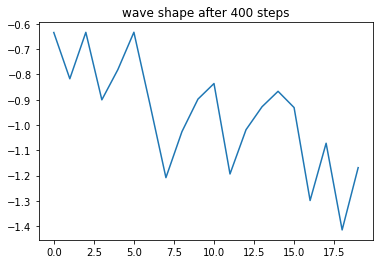

 80%|████████  | 401/500 [05:39<01:31,  1.08it/s]

Training Step: 401
generator loss:0.7147413654600526
-----------------------


 80%|████████  | 402/500 [05:40<01:27,  1.12it/s]

total discriminator loss:0.6840332699555569
average true return:0.49186318452458655
-----------------------
Training Step: 402
generator loss:0.7168995734541157
-----------------------


 81%|████████  | 403/500 [05:41<01:24,  1.14it/s]

total discriminator loss:0.6733589814375783
average true return:0.48398892740823307
-----------------------
Training Step: 403
generator loss:0.7080161004103003
-----------------------


 81%|████████  | 404/500 [05:42<01:22,  1.17it/s]

total discriminator loss:0.6595654044063255
average true return:0.48010007112333664
-----------------------
Training Step: 404
generator loss:0.7384078134775198
-----------------------


 81%|████████  | 405/500 [05:43<01:20,  1.18it/s]

total discriminator loss:0.656626460114407
average true return:0.4836084348297867
-----------------------
Training Step: 405
generator loss:0.7608411632293026
-----------------------


 81%|████████  | 406/500 [05:44<01:18,  1.20it/s]

total discriminator loss:0.6481760926022768
average true return:0.47653230056500595
-----------------------
Training Step: 406
generator loss:0.7634276543677084
-----------------------


 81%|████████▏ | 407/500 [05:44<01:17,  1.20it/s]

total discriminator loss:0.6426482332170264
average true return:0.47596217765020943
-----------------------
Training Step: 407
generator loss:0.7664763747263654
-----------------------


 82%|████████▏ | 408/500 [05:45<01:16,  1.20it/s]

total discriminator loss:0.6470861957559716
average true return:0.4751695859935835
-----------------------
Training Step: 408
generator loss:0.7715393805775101
-----------------------


 82%|████████▏ | 409/500 [05:46<01:15,  1.21it/s]

total discriminator loss:0.6638723436806608
average true return:0.4763017329317608
-----------------------
Training Step: 409
generator loss:0.7875447961940545
-----------------------


 82%|████████▏ | 410/500 [05:47<01:14,  1.21it/s]

total discriminator loss:0.6615852351092246
average true return:0.4816311272958348
-----------------------
Training Step: 410
generator loss:0.810267025354992
-----------------------


 82%|████████▏ | 411/500 [05:48<01:13,  1.21it/s]

total discriminator loss:0.6568462379789288
average true return:0.47566473298420203
-----------------------
Training Step: 411
generator loss:0.8271681045813457
-----------------------


 82%|████████▏ | 412/500 [05:49<01:12,  1.21it/s]

total discriminator loss:0.6356434293835362
average true return:0.4699020517393625
-----------------------
Training Step: 412
generator loss:0.840684230021145
-----------------------


 83%|████████▎ | 413/500 [05:49<01:11,  1.22it/s]

total discriminator loss:0.6230259566852321
average true return:0.46989495396717773
-----------------------
Training Step: 413
generator loss:0.85018259346553
-----------------------


 83%|████████▎ | 414/500 [05:50<01:10,  1.22it/s]

total discriminator loss:0.6103635276605204
average true return:0.4721323836007746
-----------------------
Training Step: 414
generator loss:0.8494297214548382
-----------------------


 83%|████████▎ | 415/500 [05:51<01:09,  1.22it/s]

total discriminator loss:0.891258771276537
average true return:0.47235265889618167
-----------------------
Training Step: 415
generator loss:0.8338794050541066
-----------------------


 83%|████████▎ | 416/500 [05:52<01:08,  1.22it/s]

total discriminator loss:0.6007185771761856
average true return:0.4756601712953559
-----------------------
Training Step: 416
generator loss:0.8400580694883689
-----------------------


 83%|████████▎ | 417/500 [05:53<01:08,  1.22it/s]

total discriminator loss:0.9027579567522994
average true return:0.48420529180817173
-----------------------
Training Step: 417
generator loss:0.8116283329760551
-----------------------


 84%|████████▎ | 418/500 [05:53<01:07,  1.21it/s]

total discriminator loss:0.5790126038981009
average true return:0.48439601861121123
-----------------------
Training Step: 418
generator loss:0.790409470244362
-----------------------


 84%|████████▍ | 419/500 [05:54<01:06,  1.21it/s]

total discriminator loss:0.8943019009477995
average true return:0.4939348430571364
-----------------------
Training Step: 419
generator loss:0.7707192383637229
-----------------------


 84%|████████▍ | 420/500 [05:55<01:05,  1.22it/s]

total discriminator loss:0.58933866260157
average true return:0.49624523059667736
-----------------------
Training Step: 420
generator loss:0.7553184488787017
-----------------------


 84%|████████▍ | 421/500 [05:56<01:04,  1.22it/s]

total discriminator loss:0.6029917373304852
average true return:0.501864094613302
-----------------------
Training Step: 421
generator loss:0.7557285508658156
-----------------------


 84%|████████▍ | 422/500 [05:57<01:03,  1.22it/s]

total discriminator loss:0.8891883720420424
average true return:0.5079574377327567
-----------------------
Training Step: 422
generator loss:0.7406260199271986
-----------------------


 85%|████████▍ | 423/500 [05:58<01:03,  1.22it/s]

total discriminator loss:0.6008163525831703
average true return:0.5093783253213147
-----------------------
Training Step: 423
generator loss:0.7366651719274716
-----------------------


 85%|████████▍ | 424/500 [05:58<01:02,  1.22it/s]

total discriminator loss:0.5961470550325207
average true return:0.5135433410194886
-----------------------
Training Step: 424
generator loss:0.7363176692031932
-----------------------


 85%|████████▌ | 425/500 [05:59<01:01,  1.22it/s]

total discriminator loss:0.5966084782444394
average true return:0.5159124593247261
-----------------------
Training Step: 425
generator loss:0.7345096234906808
-----------------------
total discriminator loss:0.5981367870118928
average true return:0.5171491511804909
-----------------------
tf.Tensor([[1 0 3 1 0 2 0 3 0 3 3 0 2 3 0 0 1 3 0 3]], shape=(1, 20), dtype=int64)


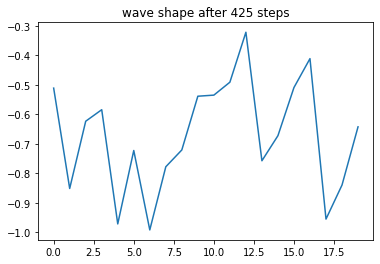

 85%|████████▌ | 426/500 [06:00<01:07,  1.10it/s]

Training Step: 426
generator loss:0.7427668154212637
-----------------------


 85%|████████▌ | 427/500 [06:01<01:06,  1.10it/s]

total discriminator loss:0.582915688012509
average true return:0.5138276475353634
-----------------------
Training Step: 427
generator loss:0.7427364883127212
-----------------------


 86%|████████▌ | 428/500 [06:02<01:03,  1.13it/s]

total discriminator loss:0.5868325337958993
average true return:0.515326379678376
-----------------------
Training Step: 428
generator loss:0.7491560487699123
-----------------------


 86%|████████▌ | 429/500 [06:03<01:01,  1.16it/s]

total discriminator loss:0.5686700470536803
average true return:0.5112426061828872
-----------------------
Training Step: 429
generator loss:0.7534366824667711
-----------------------


 86%|████████▌ | 430/500 [06:04<00:59,  1.18it/s]

total discriminator loss:0.9122591443671075
average true return:0.5111794679351169
-----------------------
Training Step: 430
generator loss:0.7708670549615353
-----------------------


 86%|████████▌ | 431/500 [06:05<00:58,  1.19it/s]

total discriminator loss:0.5585417203972115
average true return:0.5080495948801328
-----------------------
Training Step: 431
generator loss:0.7806612958252189
-----------------------


 86%|████████▋ | 432/500 [06:05<00:56,  1.20it/s]

total discriminator loss:0.5711544985354926
average true return:0.5031352203226493
-----------------------
Training Step: 432
generator loss:0.7845738102837991
-----------------------


 87%|████████▋ | 433/500 [06:06<00:55,  1.20it/s]

total discriminator loss:0.5643193962894643
average true return:0.4996026073012081
-----------------------
Training Step: 433
generator loss:0.7919725367668201
-----------------------


 87%|████████▋ | 434/500 [06:07<00:55,  1.20it/s]

total discriminator loss:0.5615443548671433
average true return:0.49842459747126744
-----------------------
Training Step: 434
generator loss:0.7899582280583881
-----------------------


 87%|████████▋ | 435/500 [06:08<00:53,  1.21it/s]

total discriminator loss:0.548460306457736
average true return:0.5013989930656184
-----------------------
Training Step: 435
generator loss:0.8022414818372725
-----------------------


 87%|████████▋ | 436/500 [06:09<00:52,  1.21it/s]

total discriminator loss:0.5400237175508782
average true return:0.5013985430515135
-----------------------
Training Step: 436
generator loss:0.8040107333847163
-----------------------


 87%|████████▋ | 437/500 [06:09<00:51,  1.21it/s]

total discriminator loss:0.5311401415041519
average true return:0.5026856833395853
-----------------------
Training Step: 437
generator loss:0.8093911635285793
-----------------------


 88%|████████▊ | 438/500 [06:10<00:51,  1.21it/s]

total discriminator loss:0.5213502154435052
average true return:0.5047008197664482
-----------------------
Training Step: 438
generator loss:0.7993899499116277
-----------------------


 88%|████████▊ | 439/500 [06:11<00:50,  1.21it/s]

total discriminator loss:0.5212848281227545
average true return:0.5118288984710202
-----------------------
Training Step: 439
generator loss:0.792618174993984
-----------------------


 88%|████████▊ | 440/500 [06:12<00:49,  1.22it/s]

total discriminator loss:0.510676504150246
average true return:0.5134633620474888
-----------------------
Training Step: 440
generator loss:0.7893474006469356
-----------------------


 88%|████████▊ | 441/500 [06:13<00:49,  1.18it/s]

total discriminator loss:0.5046436232849904
average true return:0.5194940764741462
-----------------------
Training Step: 441
generator loss:0.804009236063135
-----------------------


 88%|████████▊ | 442/500 [06:14<00:48,  1.19it/s]

total discriminator loss:0.4970193742858178
average true return:0.5199995761392426
-----------------------
Training Step: 442
generator loss:0.8093513249041765
-----------------------


 89%|████████▊ | 443/500 [06:14<00:47,  1.20it/s]

total discriminator loss:0.49550977150372333
average true return:0.5157311764310731
-----------------------
Training Step: 443
generator loss:0.8215340723807079
-----------------------


 89%|████████▉ | 444/500 [06:15<00:46,  1.20it/s]

total discriminator loss:0.49352219653826956
average true return:0.5122728651127569
-----------------------
Training Step: 444
generator loss:0.8409744102263033
-----------------------


 89%|████████▉ | 445/500 [06:16<00:45,  1.21it/s]

total discriminator loss:0.47160769586758045
average true return:0.5100685111966008
-----------------------
Training Step: 445
generator loss:0.855099052786877
-----------------------


 89%|████████▉ | 446/500 [06:17<00:44,  1.21it/s]

total discriminator loss:0.47368992160135315
average true return:0.5087320237131461
-----------------------
Training Step: 446
generator loss:0.8706704218628878
-----------------------


 89%|████████▉ | 447/500 [06:18<00:43,  1.21it/s]

total discriminator loss:0.4694347367911853
average true return:0.5057596875780366
-----------------------
Training Step: 447
generator loss:0.9050169543542415
-----------------------


 90%|████████▉ | 448/500 [06:19<00:42,  1.21it/s]

total discriminator loss:0.47622476243104345
average true return:0.49908070565191476
-----------------------
Training Step: 448
generator loss:0.939886766110167
-----------------------


 90%|████████▉ | 449/500 [06:19<00:42,  1.20it/s]

total discriminator loss:0.44788429061777607
average true return:0.49184469598757435
-----------------------
Training Step: 449
generator loss:0.9690108783905436
-----------------------


 90%|█████████ | 450/500 [06:20<00:42,  1.19it/s]

total discriminator loss:0.4328652620402549
average true return:0.48692002376266824
-----------------------
Training Step: 450
generator loss:1.002402118304028
-----------------------
total discriminator loss:0.42634974625399424
average true return:0.4832588153285976
-----------------------
tf.Tensor([[2 0 3 2 2 1 3 0 3 3 0 3 2 1 3 1 0 1 0 1]], shape=(1, 20), dtype=int64)


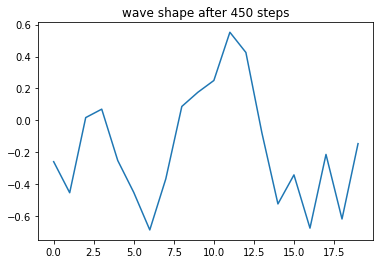

 90%|█████████ | 451/500 [06:22<00:46,  1.04it/s]

Training Step: 451
generator loss:1.0301028200513151
-----------------------


 90%|█████████ | 452/500 [06:22<00:44,  1.07it/s]

total discriminator loss:0.42053637932790855
average true return:0.47771337206757614
-----------------------
Training Step: 452
generator loss:1.0633652126296411
-----------------------


 91%|█████████ | 453/500 [06:23<00:43,  1.09it/s]

total discriminator loss:0.4244998354792788
average true return:0.4744571040499294
-----------------------
Training Step: 453
generator loss:1.0817142470383088
-----------------------


 91%|█████████ | 454/500 [06:24<00:41,  1.10it/s]

total discriminator loss:1.480499310737557
average true return:0.47363123792469064
-----------------------
Training Step: 454
generator loss:1.088856955137588
-----------------------


 91%|█████████ | 455/500 [06:25<00:40,  1.10it/s]

total discriminator loss:0.42779037727951064
average true return:0.4716830655424347
-----------------------
Training Step: 455
generator loss:1.0941930158811233
-----------------------


 91%|█████████ | 456/500 [06:26<00:39,  1.12it/s]

total discriminator loss:0.41597705692336917
average true return:0.4668204056421582
-----------------------
Training Step: 456
generator loss:1.0948525175663215
-----------------------


 91%|█████████▏| 457/500 [06:27<00:37,  1.14it/s]

total discriminator loss:0.3950526510401965
average true return:0.46391233967071654
-----------------------
Training Step: 457
generator loss:1.0955807542676306
-----------------------


 92%|█████████▏| 458/500 [06:28<00:36,  1.15it/s]

total discriminator loss:1.4689562759975408
average true return:0.46594351227004493
-----------------------
Training Step: 458
generator loss:1.0840691574088719
-----------------------


 92%|█████████▏| 459/500 [06:29<00:35,  1.15it/s]

total discriminator loss:0.42539337889414364
average true return:0.4625553517706992
-----------------------
Training Step: 459
generator loss:1.0747139339474
-----------------------


 92%|█████████▏| 460/500 [06:29<00:35,  1.14it/s]

total discriminator loss:0.44681221432060464
average true return:0.4643549009948147
-----------------------
Training Step: 460
generator loss:1.0684703816985313
-----------------------


 92%|█████████▏| 461/500 [06:30<00:33,  1.15it/s]

total discriminator loss:0.4117570161805223
average true return:0.46539109825187086
-----------------------
Training Step: 461
generator loss:1.0621578580706394
-----------------------


 92%|█████████▏| 462/500 [06:31<00:32,  1.16it/s]

total discriminator loss:0.4345643033785032
average true return:0.46714233674626104
-----------------------
Training Step: 462
generator loss:1.0501108935445154
-----------------------


 93%|█████████▎| 463/500 [06:32<00:32,  1.15it/s]

total discriminator loss:1.424125466757737
average true return:0.46849019983643414
-----------------------
Training Step: 463
generator loss:1.0351690416428658
-----------------------


 93%|█████████▎| 464/500 [06:33<00:31,  1.14it/s]

total discriminator loss:0.43038504701854247
average true return:0.4675034513271258
-----------------------
Training Step: 464
generator loss:1.028097402258429
-----------------------


 93%|█████████▎| 465/500 [06:34<00:30,  1.15it/s]

total discriminator loss:0.4171201551271676
average true return:0.4666153930689355
-----------------------
Training Step: 465
generator loss:1.006450245219194
-----------------------


 93%|█████████▎| 466/500 [06:35<00:29,  1.16it/s]

total discriminator loss:0.4063835705075681
average true return:0.4688702755005888
-----------------------
Training Step: 466
generator loss:0.9960207218843151
-----------------------


 93%|█████████▎| 467/500 [06:36<00:29,  1.12it/s]

total discriminator loss:0.4186008273748445
average true return:0.4706308952570909
-----------------------
Training Step: 467
generator loss:0.9869453330366011
-----------------------


 94%|█████████▎| 468/500 [06:36<00:27,  1.14it/s]

total discriminator loss:0.4263294756886168
average true return:0.472141902317547
-----------------------
Training Step: 468
generator loss:0.978481570589697
-----------------------


 94%|█████████▍| 469/500 [06:37<00:27,  1.15it/s]

total discriminator loss:0.42125093268660885
average true return:0.4712254098331129
-----------------------
Training Step: 469
generator loss:0.9769657962767437
-----------------------


 94%|█████████▍| 470/500 [06:38<00:26,  1.15it/s]

total discriminator loss:0.43312162311254454
average true return:0.4728461455028735
-----------------------
Training Step: 470
generator loss:0.9627458431514362
-----------------------


 94%|█████████▍| 471/500 [06:39<00:25,  1.15it/s]

total discriminator loss:0.4312281846012318
average true return:0.47507811410257755
-----------------------
Training Step: 471
generator loss:0.9581440838653835
-----------------------


 94%|█████████▍| 472/500 [06:40<00:24,  1.14it/s]

total discriminator loss:0.42097502708600776
average true return:0.47617525746649497
-----------------------
Training Step: 472
generator loss:0.9509152773341949
-----------------------


 95%|█████████▍| 473/500 [06:41<00:23,  1.15it/s]

total discriminator loss:1.348587519710223
average true return:0.4779264375634952
-----------------------
Training Step: 473
generator loss:0.9425171662069196
-----------------------


 95%|█████████▍| 474/500 [06:42<00:22,  1.14it/s]

total discriminator loss:0.43879389873640817
average true return:0.47779681258659734
-----------------------
Training Step: 474
generator loss:0.9322663841409081
-----------------------


 95%|█████████▌| 475/500 [06:42<00:21,  1.14it/s]

total discriminator loss:0.4298658355259889
average true return:0.48003973311844206
-----------------------
Training Step: 475
generator loss:0.9225733168864928
-----------------------
total discriminator loss:0.44331757881104367
average true return:0.48144489458935025
-----------------------
tf.Tensor([[1 2 2 1 0 0 1 2 0 0 2 2 2 1 2 1 3 2 2 2]], shape=(1, 20), dtype=int64)


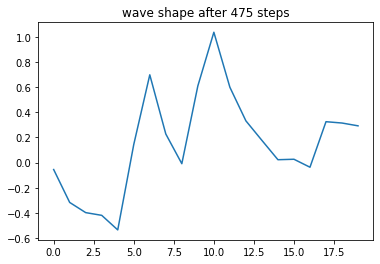

 95%|█████████▌| 476/500 [06:44<00:23,  1.03it/s]

Training Step: 476
generator loss:0.9192670801596446
-----------------------


 95%|█████████▌| 477/500 [06:45<00:22,  1.04it/s]

total discriminator loss:0.4352215485453277
average true return:0.4797254375015492
-----------------------
Training Step: 477
generator loss:0.9078402032058874
-----------------------


 96%|█████████▌| 478/500 [06:45<00:20,  1.08it/s]

total discriminator loss:1.279523294592676
average true return:0.481506865140999
-----------------------
Training Step: 478
generator loss:0.887036412253539
-----------------------


 96%|█████████▌| 479/500 [06:46<00:18,  1.11it/s]

total discriminator loss:0.4438954739590638
average true return:0.4839882884667608
-----------------------
Training Step: 479
generator loss:0.858106014818416
-----------------------


 96%|█████████▌| 480/500 [06:47<00:17,  1.14it/s]

total discriminator loss:0.46723507404669107
average true return:0.4916701383262174
-----------------------
Training Step: 480
generator loss:0.8253551240866732
-----------------------


 96%|█████████▌| 481/500 [06:48<00:16,  1.16it/s]

total discriminator loss:0.5129653544035715
average true return:0.5018981593996208
-----------------------
Training Step: 481
generator loss:0.7761762078194931
-----------------------


 96%|█████████▋| 482/500 [06:49<00:15,  1.16it/s]

total discriminator loss:0.5135048550680712
average true return:0.5137592710634793
-----------------------
Training Step: 482
generator loss:0.7552399936240243
-----------------------


 97%|█████████▋| 483/500 [06:50<00:14,  1.16it/s]

total discriminator loss:0.5364602779758937
average true return:0.5201313373171486
-----------------------
Training Step: 483
generator loss:0.7515273335181893
-----------------------


 97%|█████████▋| 484/500 [06:50<00:13,  1.17it/s]

total discriminator loss:0.5228628014151346
average true return:0.5211682287464978
-----------------------
Training Step: 484
generator loss:0.753264455054389
-----------------------


 97%|█████████▋| 485/500 [06:51<00:12,  1.16it/s]

total discriminator loss:0.5367862277129042
average true return:0.522047700722073
-----------------------
Training Step: 485
generator loss:0.7611354454005328
-----------------------


 97%|█████████▋| 486/500 [06:52<00:11,  1.18it/s]

total discriminator loss:0.5228349554166563
average true return:0.5216679383940455
-----------------------
Training Step: 486
generator loss:0.7632020027853399
-----------------------


 97%|█████████▋| 487/500 [06:53<00:11,  1.14it/s]

total discriminator loss:0.5299921464896382
average true return:0.5226310872147041
-----------------------
Training Step: 487
generator loss:0.7708975830160059
-----------------------


 98%|█████████▊| 488/500 [06:54<00:10,  1.16it/s]

total discriminator loss:0.5094664722243045
average true return:0.5238355541746237
-----------------------
Training Step: 488
generator loss:0.7781311824540722
-----------------------


 98%|█████████▊| 489/500 [06:55<00:09,  1.15it/s]

total discriminator loss:0.5240614694690723
average true return:0.5262581471006841
-----------------------
Training Step: 489
generator loss:0.7940058777007639
-----------------------


 98%|█████████▊| 490/500 [06:56<00:08,  1.15it/s]

total discriminator loss:0.49991000275975667
average true return:0.5280489809690745
-----------------------
Training Step: 490
generator loss:0.8010770233657007
-----------------------


 98%|█████████▊| 491/500 [06:57<00:07,  1.16it/s]

total discriminator loss:0.49406388352312225
average true return:0.5299600901989239
-----------------------
Training Step: 491
generator loss:0.8147719123684407
-----------------------


 98%|█████████▊| 492/500 [06:57<00:06,  1.18it/s]

total discriminator loss:1.1903110465816746
average true return:0.5292864460977398
-----------------------
Training Step: 492
generator loss:0.8255324879693973
-----------------------


 99%|█████████▊| 493/500 [06:58<00:05,  1.17it/s]

total discriminator loss:0.4984672669098817
average true return:0.5281587216548788
-----------------------
Training Step: 493
generator loss:0.8390741037349375
-----------------------


 99%|█████████▉| 494/500 [06:59<00:05,  1.16it/s]

total discriminator loss:0.47432798037723745
average true return:0.5228973812023872
-----------------------
Training Step: 494
generator loss:0.8434126433011478
-----------------------


 99%|█████████▉| 495/500 [07:00<00:04,  1.17it/s]

total discriminator loss:0.472058409658332
average true return:0.5203702491860092
-----------------------
Training Step: 495
generator loss:0.8548563555523254
-----------------------


 99%|█████████▉| 496/500 [07:01<00:03,  1.15it/s]

total discriminator loss:0.4813347181264879
average true return:0.5142589495630979
-----------------------
Training Step: 496
generator loss:0.8739705955921161
-----------------------


 99%|█████████▉| 497/500 [07:02<00:02,  1.16it/s]

total discriminator loss:0.49945123981944123
average true return:0.5094318849867459
-----------------------
Training Step: 497
generator loss:0.879860546891581
-----------------------


100%|█████████▉| 498/500 [07:03<00:01,  1.18it/s]

total discriminator loss:0.47627822275786913
average true return:0.5074625081719778
-----------------------
Training Step: 498
generator loss:0.8927179042533562
-----------------------


100%|█████████▉| 499/500 [07:03<00:00,  1.19it/s]

total discriminator loss:0.4866429568411428
average true return:0.5029244053211226
-----------------------
Training Step: 499
generator loss:0.89777937550207
-----------------------


100%|██████████| 500/500 [07:04<00:00,  1.18it/s]

total discriminator loss:0.4650290326777602
average true return:0.5036030859317391
-----------------------


In [34]:
_TOTAL_STEPS = 500
historical_avg = HistoricalAvgLoss(G)
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch

    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer, 
                                          loss_obj=historical_avg_G)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True,
                                                                loss_obj=historical_avg_D)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())
        
        
    if step % 25 == 0:
        _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(1, G, BATCH_SIZE, T)
        plt.figure()
        print(tf.argmax(_gen_seqs_et, axis=2))
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()
        
    step += 1

Text(0.5, 0, 'Training steps')

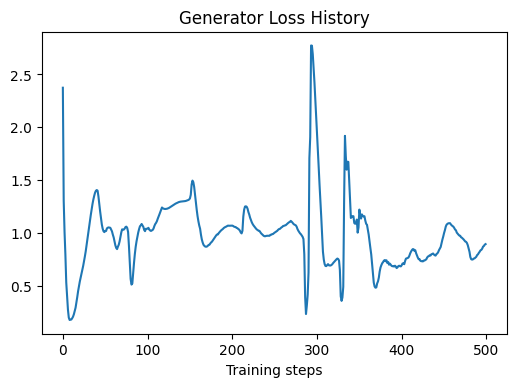

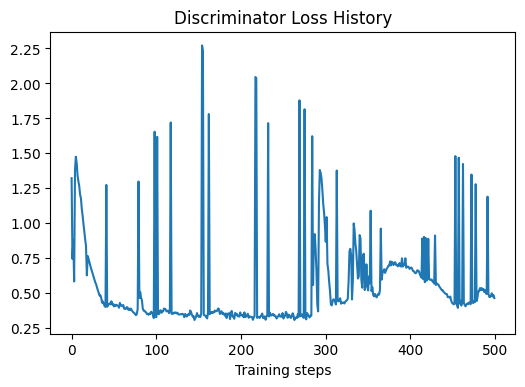

In [36]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

## Compare between G0, G1 and G2

In [80]:
from matplotlib import pyplot as plt

tf.Tensor(
[[3 3 1 3 2 3 1 2 0 3 1 2 1 1 1 0 2 3 0 3]
 [0 0 3 3 0 1 3 3 0 0 0 1 0 0 1 1 2 1 2 3]
 [3 2 0 0 0 3 0 2 0 0 3 2 1 3 2 1 3 0 0 0]
 [0 2 0 0 2 3 0 2 0 2 2 0 1 0 3 3 3 2 1 2]
 [2 0 1 0 1 2 1 2 3 1 0 0 0 2 3 3 3 1 0 0]
 [1 3 3 2 2 2 2 0 0 0 1 1 2 0 3 0 0 3 0 0]
 [3 0 2 1 3 0 0 1 1 0 3 0 3 0 3 0 1 1 2 2]
 [0 2 0 2 3 1 2 0 2 0 1 3 1 3 2 3 0 2 3 1]
 [3 3 0 1 1 0 3 0 3 2 3 2 3 1 0 0 0 2 0 1]
 [1 2 2 3 2 2 0 2 2 1 0 0 0 1 3 3 1 0 2 2]], shape=(10, 20), dtype=int64)


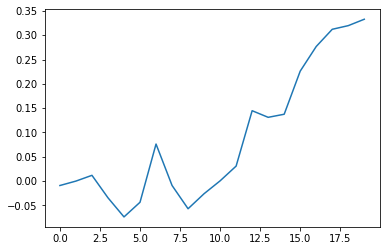

In [81]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
seqs_random_et, seqs_random_ts = generate_sequences_gumbel(10, G0, BATCH_SIZE, T)
print(tf.argmax(seqs_random_et, axis=2))

ind = 1
x = np.arange(seqs_random_ts[ind,:,:].shape[0])
y = seqs_random_ts[ind,:,:]

plt.plot(x, y)

tf.Tensor(
[[0 1 2 3 1 2 2 3 1 3 1 2 1 2 1 0 2 1 3 1]
 [2 1 0 0 1 1 2 2 2 3 3 2 2 1 0 3 1 2 2 1]
 [2 1 1 0 1 1 2 1 3 2 2 2 1 3 3 2 0 2 1 3]
 [0 2 3 1 0 1 1 2 1 0 2 2 0 2 1 3 2 1 0 2]
 [2 2 1 0 2 2 3 3 3 2 3 2 1 0 2 0 2 0 3 1]
 [3 2 2 3 2 1 1 1 2 0 2 1 0 2 1 1 2 2 2 0]
 [3 1 0 1 2 2 3 2 2 0 2 0 2 3 3 1 2 1 2 2]
 [2 2 3 3 1 1 1 2 0 2 2 1 0 0 2 1 0 2 1 1]
 [3 2 2 1 3 2 1 0 2 1 2 0 0 2 3 1 0 2 0 1]
 [2 0 1 2 0 2 2 3 3 1 3 2 1 0 3 2 2 1 3 0]], shape=(10, 20), dtype=int64)


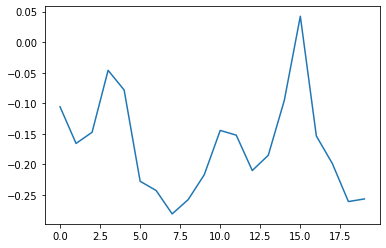

In [82]:
G1 = pretrained_generator
seqs_pretrained_et, seqs_pretrained_ts = generate_sequences_gumbel(10, G1, BATCH_SIZE, T)
print(tf.argmax(seqs_pretrained_et, axis=2))

ind = 1
x = np.arange(seqs_pretrained_ts[ind,:,:].shape[0])
y = seqs_pretrained_ts[ind,:,:]

plt.plot(x, y)

tf.Tensor(
[[2 0 3 1 2 1 0 2 3 2 2 1 0 2 2 3 2 1 1 3]
 [1 1 1 0 2 3 1 2 3 1 1 1 0 2 2 0 1 0 3 1]
 [2 2 2 3 2 3 2 1 0 2 1 0 2 3 2 1 2 0 1 2]
 [0 2 2 1 0 1 0 1 0 0 2 2 2 3 0 0 0 2 2 1]
 [0 0 1 2 3 1 2 3 3 2 3 1 2 0 2 0 2 1 2 0]
 [2 3 1 1 0 2 1 2 2 1 0 0 3 2 3 2 2 0 3 2]
 [2 3 1 2 1 2 0 1 2 2 3 2 1 0 3 2 2 2 2 2]
 [3 1 0 1 0 1 3 1 2 2 2 1 1 2 0 1 2 2 3 1]
 [3 1 2 2 0 2 1 2 0 1 2 3 1 1 0 1 2 2 2 2]
 [1 0 1 2 1 0 3 2 2 3 2 0 1 1 1 2 2 0 1 0]], shape=(10, 20), dtype=int64)


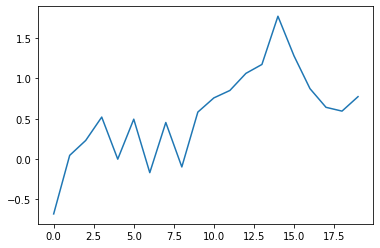

In [83]:
G2 = G
seqs_trained_et, seqs_trained_ts = generate_sequences_gumbel(10, G2, BATCH_SIZE, T)

print(tf.argmax(seqs_trained_et, axis=2))

ind = 3
x = np.arange(seqs_trained_ts[ind,:,:].shape[0])
y = seqs_trained_ts[ind,:,:]

plt.plot(x, y)

## Save trained G and D weights

In [75]:
if not os.path.exists(model_save_dir + '/G_run_syn_v11_200'):
    os.makedirs(model_save_dir + '/G_run_syn_v11_200')

G_save_path = model_save_dir + '/G_run_syn_v11_200/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_syn_v11_200'):
    os.makedirs(model_save_dir + '/D_run_syn_v11_200')

D_save_path = model_save_dir + '/D_run_syn_v11_200/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)

## Generate Synthesized data

In [87]:
G_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/G_run_syn_v11_200/model.tf'

In [88]:
G_200 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G_200.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_16 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [145]:
raw_seqs_trained_et_200, raw_seqs_trained_ts_200 = generate_sequences_gumbel(400000, G_200, BATCH_SIZE, T)

In [148]:
seqs_save_et_200 = tf.argmax(raw_seqs_trained_et_200[:400000, :, :], axis=2)
seqs_save_ts_200 = apply_mean_std(raw_seqs_trained_ts_200[:400000, :, :], *get_mean_std(raw_pos_timestamp_seqs))

In [151]:
import pickle

pos_seqs_filename_et = 'syn_positive_type_sequences.pickle'
pos_seqs_filename_ts = 'syn_positive_time_sequences.pickle'

repo_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"

with open(os.path.join(repo_path, 'syn_data', 'combined_v0', pos_seqs_filename_et), 'wb') as f:
    pickle.dump(seqs_save_et_200, f)
    
with open(os.path.join(repo_path, 'syn_data', 'combined_v0', pos_seqs_filename_ts), 'wb') as f:
    pickle.dump(seqs_save_ts_200, f)